
# **COLORAZIONE AUTOMATICA DI IMMAGINI: AUTOENCODER**
---


# Introduzione

Questo notebook si propone di esplorare a fondo una classe di architetture del deep learning: gli **AUTOENCODER**.

In particolare, ci concentreremo sull'implementazione e l'analisi di **tre diverse configurazioni** di autoencoder, **valutandone le prestazioni** nel contesto della colorazione automatica delle immagini.

Un aspetto chiave di questa esplorazione sarà il **confronto** tra **due differenti codifiche colore: RGB e LAB**, per comprenderne l'impatto sull'*efficacia* del *processo di colorazione*.


## Che cosa è un autoencoder ?
Un ***autoencoder*** è una rete neurale progettata per apprendere *rappresentazioni compatte* e *significative* dei dati. Nel contesto della colorazione, viene utilizzato per analizzare le immagini in scala di grigi e generare una versione a colori partendo da una rappresentazione compressa, detta anche ***spazio latente***.


## Qual è la struttura di un autoencoder ?
Un autoencoder è composto da due parti principali: encoder e decoder. L'encoder comprime l'immagine in una rappresentazione più piccola e astratta, detta **spazio latente**, utilizzando strati convoluzionali e operazioni di downsampling. Il decoder, invece, cerca di ricostruire l'immagine originale partendo da questa rappresentazione, usando upsampling e convoluzioni.

Se l’autoencoder riesce a ricostruire l'immagine in modo fedele, significa che ha appreso una rappresentazione efficace delle informazioni essenziali. Questa capacità è alla base del suo utilizzo nella colorazione automatica: dalla versione in scala di grigi, il modello impara a generare un’immagine a colori realistica, sfruttando ciò che ha appreso sulla struttura e il contenuto visivo durante l’addestramento.

# Inclusione delle librerie utili

In [ ]:
from google.colab import drive, files
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.src import saving
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import cv2

In [ ]:
#@title Montaggio Drive
try:
    drive.mount('/content/drive')
    print("Google Drive montato con successo.")
except Exception as e:
    print(f"Errore durante il montaggio di Google Drive: {e}")
    exit()

Mounted at /content/drive
Google Drive montato con successo.


#Caricamento del dataset preprocessato

Prima di procedere con la definizione delle architetture, è fondamentale **importare i dati pre-processati** e salvati in formato `.npy`, così da poterli utilizzare direttamente senza ripetere le operazioni di pre-processing. Questi file sono stati generati nel notebook [database_managment.ipynb](https://colab.research.google.com/drive/1RlXQHRaDaFujpfJ_Oi_xRBpPUqNYXK2W).

Ricreiamo dunque **due set distinti di dati**: il primo fa riferimento alla **codifica RGB**, comprendendo sia le *immagini a colori* che quelle in *scala di grigio*; il secondo è basato sulla **codifica LAB**, con separazione del *canale L* (luminosità) e dei *canali A e B* (componenti cromatiche).

Questa suddivisione ci consente di studiare e confrontare due approcci differenti in fase di training, ciascuno fondato su una rappresentazione specifica dello spazio colore, come vedremo nelle sezioni successive.


La scelta di utilizzare le **stesse architetture** su **entrambe le codifiche colore** nasce dall’intento di ampliare il confronto tra i modelli, valutando come ciascuno si comporta in base allo spazio colore adottato durante il training.

Secondo la letteratura, lo **spazio LAB** è spesso preferito nei compiti di ricostruzione per la sua **maggiore fedeltà visiva**, ma con questo confronto vogliamo verificare sperimentalmente se tale vantaggio si conferma anche nel nostro contesto.

*L’obiettivo è capire se alcune architetture si adattino meglio a una codifica rispetto all’altra, oppure se **emergano differenze inattese** in termini di **performance** o **qualità visiva**.*

Questa analisi comparativa, basata su evidenze empiriche, ci permette di approfondire l’impatto della scelta dello spazio colore nel processo di apprendimento e ricostruzione.

In [ ]:
#@title ##RGB
color_img = np.load('/content/drive/MyDrive/DL_project/processed_dataset/RGB/color_img.npy')
gray_img = np.load('/content/drive/MyDrive/DL_project/processed_dataset/RGB/gray_img.npy')

# Per assicurarci che i dati siano stati importati correttamente, visualizziamo le dimensioni (shape) di ciascun array caricato.
print(f"Shape immagini a colori: {color_img.shape}")
print(f"Shape immagini in scala di grigio: {gray_img.shape}")

Shape immagini a colori: (7129, 128, 128, 3)
Shape immagini in scala di grigio: (7129, 128, 128, 1)


In [ ]:
#@title ##LAB
L = np.load('/content/drive/MyDrive/DL_project/processed_dataset/LAB/L_channels.npy')
AB = np.load('/content/drive/MyDrive/DL_project/processed_dataset/LAB/AB_channels.npy')

# Per assicurarci che i dati siano stati importati correttamente, visualizziamo (anche in questo caso) le dimensioni (shape) di ciascun array caricato.
print(f"Shape immagini con canali AB: {AB.shape}")
print(f"Shape immagini con canale L (luminanza): {L.shape}")

Shape immagini con canali AB: (7129, 128, 128, 2)
Shape immagini con canale L (luminanza): (7129, 128, 128, 1)


#Suddivisione del dataset in train, test e validation


Per l'organizzazione dei nostri set di dati, è necessario eseguire due chiamate consecutive alla funzione `train_test_split()`.

La prima chiamata ha lo scopo di isolare il set di test.

Questo sottoinsieme di dati verrà temporaneamente accantonato e sarà impiegato esclusivamente in una fase finale di valutazione, al fine di stimare le prestazioni del modello in termini di capacità di generalizzazione, ovvero di applicare correttamente la colorazione anche su immagini che non ha mai visto prima.

L'insieme rimanente da questa prima suddivisione diventerà l'input di una seconda chiamata a `train_test_split()`. Questa ulteriore operazione separerà i dati nei due set fondamentali per l'apprendimento automatico: il set di addestramento (training), su cui il modello imparerà, e il set di validazione (validation), utilizzato per monitorare il progresso dell'addestramento.

*È importante notare che questa sequenza di passaggi di suddivisione dovrà essere applicata coerentemente sia al set di immagini a colori che a quello in scala di grigi, assicurando la corretta corrispondenza tra input e output in tutte le fasi di training e valutazione.*

Le sequenze di passi da eseguire per splittare il set di dati nello spazio colore LAB sono identiche (quindi due in sequenza), eccetto che per il risultato: nel pre-processing, infatti, è stata evidenziata la suddivisione della codifica tra informazioni luminose (L) e informazioni cromatiche (AB); coerentemente, anche le operazioni di split saranno applicate seguendo tale approccio.

In [ ]:
#@title ##RGB
# Effettuiamo le chiamate a train_test_split con un random_state prefissato in modo da rendere ripetibile
# l'output e garantire che lo shuffle dei dati prima dello split sia sempre uguale

# Teniamo come set di test un 20% delle immagini del dataset
X_gray, X_gray_test, y_color, y_color_test = train_test_split(gray_img, color_img, test_size=0.2, random_state=21)

# Dividiamo una seconda volta per ottenere un set di train e uno di validation, teniamo un 18% delle immagini come set di validation
X_gray_train, X_gray_val, y_color_train, y_color_val = train_test_split(X_gray, y_color, test_size=0.18, random_state=21)

# Verifichiamo ora le shape dei rispettivi set per verificare la corretta suddivisione
print(f"X_gray_train (immagini di training in scala di grigio): {X_gray_train.shape}")
print(f"y_color_train (immagini di training a colori): {y_color_train.shape}")
print(f"X_gray_val (immagini di validation in scala di grigio): {X_gray_val.shape}")
print(f"y_color_val (immagini di validation a colori): {y_color_val.shape}")
print(f"X_gray_test (immagini di test in scala di grigio): {X_gray_test.shape}")
print(f"y_color_test (immagini di test a colori): {y_color_test.shape}")

X_gray_train (immagini di training in scala di grigio): (4676, 128, 128, 1)
y_color_train (immagini di training a colori): (4676, 128, 128, 3)
X_gray_val (immagini di validation in scala di grigio): (1027, 128, 128, 1)
y_color_val (immagini di validation a colori): (1027, 128, 128, 3)
X_gray_test (immagini di test in scala di grigio): (1426, 128, 128, 1)
y_color_test (immagini di test a colori): (1426, 128, 128, 3)


In [ ]:
#@title ##LAB
# Effettuiamo le chiamate a train_test_split con un random_state prefissato in modo da rendere ripetibile
# l'output e garantire che lo shuffle dei dati prima dello split sia sempre uguale

# Teniamo come set di test un 20% delle immagini del dataset
X_L, X_L_test, y_AB, y_AB_test = train_test_split(L, AB, test_size=0.2, random_state=21)

# Dividiamo una seconda volta per ottenere un set di train e uno di validation, teniamo un 18% delle immagini come set di validation
X_L_train, X_L_val, y_AB_train, y_AB_val = train_test_split(X_L, y_AB, test_size=0.18, random_state=21)

# Verifichiamo ora le shap dei rispettivi set per verificare la suddivisione
print(f"X_L_train (immagini di training in scala di grigio): {X_L_train.shape}")
print(f"y_AB_train (immagini di training a colori): {y_AB_train.shape}")
print(f"X_L_val (immagini di validation in scala di grigio): {X_L_val.shape}")
print(f"y_AB_val (immagini di validation a colori): {y_AB_val.shape}")
print(f"X_L_test (immagini di test in scala di grigio): {X_L_test.shape}")
print(f"y_AB_test (immagini di test a colori): {y_AB_test.shape}")

X_L_train (immagini di training in scala di grigio): (4676, 128, 128, 1)
y_AB_train (immagini di training a colori): (4676, 128, 128, 2)
X_L_val (immagini di validation in scala di grigio): (1027, 128, 128, 1)
y_AB_val (immagini di validation a colori): (1027, 128, 128, 2)
X_L_test (immagini di test in scala di grigio): (1426, 128, 128, 1)
y_AB_test (immagini di test a colori): (1426, 128, 128, 2)


# Colorization Autoencoder 1 - MaxPooling e Conv2dTranspose

La prima architettura proposta si ispira ad un articolo scientifico trovato online, di cui si cita la fonte:

> [Image Colorization Using AutoEncoder](https://www.researchgate.net/publication/378313231_Image_Colorization_Using_AutoEncoder)

Pur seguendo lo schema generale descritto dagli autori, sono state apportate alcune modifiche, motivati dalle caratteristiche del differente dataset utilizzato e da scelte architetturali mirate a migliorare la capacità di apprendimento del modello:

- **Riduzione della profondità dell’encoder**: sono stati utilizzati 4 blocchi di `Conv2D(con attivazione ReLu)` e `MaxPooling2D()` anziché 5, in modo da preservare una dimensione sufficiente della rappresentazione latente fornita in output dall' encoder, considerando che le immagini in input sono state ridimensionate a 128×128 pixel. Questa scelta consente di mantenere un buon equilibrio tra compressione e capacità rappresentativa.

- **Sostituzione di `UpSampling2D()` con `Conv2DTranspose()` nel decoder**: i layer di upsampling originari sono stati sostituiti con Conv2DTranspose, che essendo [trainabili](https://stackoverflow.com/questions/53654310/what-is-the-difference-between-upsampling2d-and-conv2dtranspose-functions-in-ker?utm_source=chatgpt.com), consentono al modello di apprendere direttamente il processo di ricostruzione spaziale delle feature maps. Questo approccio risulta più flessibile e potenzialmente più preciso, poiché non si limita ad un'interpolazione statica dei dati.

- **Aggiunta di un ulteriore livello nel decoder**: rispetto alla versione originaria, il decoder contiene sei strati (di cui cinque Conv2DTranspose e uno finale Conv2D) per garantire una ricostruzione più progressiva e controllata dell'immagine a colori. È stata inoltre introdotta una convoluzione finale con attivazione sigmoid nel caso dell’output in formato RGB, normalizzato nel range [0, 1], oppure con attivazione tanh nel caso dell’output in formato LAB, normalizzato nel range [-1, 1].


Affinché fosse possibile definire il modello custom come classe e al contempo garantire il corretto caricamento del miglior modello tramite il metodo `load()` di Keras, abbiamo dovuto inserire una serie di accorgimenti previsti per la gestione dei *custom objects*, come descritto nella documentazione ufficiale di Keras e TensorFlow (che citiamo nelle fonti, in fondo al notebook).

In particolare, abbiamo inserito il decoratore `@saving.register_keras_serializable()` sopra la definizione della classe, così da renderla serializzabile per keras. Inoltre, abbiamo aggiunto il parametro `**kwargs` al metodo `__init__()`, per consentire il passaggio di argomenti arbitrari durante la fase di deserializzazione.

Sono stati infine introdotti due parametri aggiuntivi, `final_activation` e `final_depth`, con l’obiettivo di rendere l’architettura più flessibile e generalizzabile, in modo da poter istanziare facilmente due varianti del modello compatibili con le differenti codifiche colore (RGB e LAB) scelte e spiegate inizialmente.

In [ ]:
@saving.register_keras_serializable()

class Colorization_AE1(tf.keras.models.Model):

  def __init__(self, final_activation='sigmoid', final_depth=3, **kwargs):
    super(Colorization_AE1, self).__init__(**kwargs)
    self.final_activation = final_activation
    self.final_depth = final_depth

    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(128, 128, 1)),

      tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

      tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

      tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

      tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
      ])


    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Conv2DTranspose(512, (3, 3), activation='relu', padding='same', strides=2),
      tf.keras.layers.Conv2DTranspose(256, (3, 3), activation='relu', padding='same', strides=1),
      tf.keras.layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2),
      tf.keras.layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=1),
      tf.keras.layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2),
      tf.keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2),
      tf.keras.layers.Conv2D(final_depth, (3, 3), activation=self.final_activation, padding='same')])


  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

  def get_config(self):
          config = super().get_config()
          config.update({
              'final_activation': self.final_activation,
              'final_depth': self.final_depth
          })
          return config

  @classmethod
  def from_config(cls, config):
      return cls(**config)


A questo punto, creiamo due istanze della classe `Colorization_AE1()` poiché la funzione di attivazione del layer finale dovrà differire. Assegniamo queste istanze rispettivamente ad **`autoencoder1_RGB`** e **`autoencoder1_LAB`**.

Sebbene i layer siano stati inizializzati, i modelli non sono ancora stati "costruiti" nel senso che non hanno ancora processato alcun input. Di conseguenza, non dispongono delle informazioni necessarie (come le dimensioni intermedie dei layer) per visualizzarne la struttura interna tramite `summary()`.

Per completare la costruzione dei modelli, è sufficiente creare un input fittizio (un "**dummy input**") con la **stessa forma delle immagini reali** e su di esso eseguire un forward pass. Questo passaggio forza l'attivazione e la definizione delle dimensioni dei layer.

Una volta che i modelli sono stati così costruiti, possiamo finalmente utilizzare il metodo `summary()` per ispezionare la struttura interna di encoder e decoder di ciascuna istanza, visualizzando i layer coinvolti, l'output shape e il numero di parametri addestrabili.

In [ ]:
#@title Istanza di ae1 RGB
autoencoder1_RGB = Colorization_AE1(final_activation='sigmoid', final_depth=3)
dummy_input = tf.random.normal([1, 128, 128, 1])

# Simuliamo un forward pass con il dummy input creato sopra
autoencoder1_RGB(dummy_input)

# Stampiamo la struttura interna dell' encoder e del decoder per visulizzare i singoli livelli
autoencoder1_RGB.encoder.summary()
autoencoder1_RGB.decoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,549,824 (5.91 MB)

 Trainable params: 1,549,824 (5.91 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose_20             │ (1, 16, 16, 512)       │     2,359,808 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_21             │ (1, 16, 16, 256)       │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_22             │ (1, 32, 32, 128)       │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_23             │ (1, 32, 32, 64)        │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_24             │ (1, 64, 64, 64)        │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_25             │ (1, 128, 128, 32)      │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (1, 128, 128, 3)       │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,964,803 (15.12 MB)

 Trainable params: 3,964,803 (15.12 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#@title Istanza di ae1 LAB
autoencoder1_LAB = Colorization_AE1(final_activation='tanh', final_depth=2)
dummy_input = tf.random.normal([1, 128, 128, 1])

# Simuliamo un forward pass con il dummy input creato sopra
autoencoder1_LAB(dummy_input)

# Stampiamo la struttura interna dell' encoder e del decoder per visulizzare i singoli livelli
autoencoder1_LAB.encoder.summary()
autoencoder1_LAB.decoder.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,549,824 (5.91 MB)

 Trainable params: 1,549,824 (5.91 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose_26             │ (1, 16, 16, 512)       │     2,359,808 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_27             │ (1, 16, 16, 256)       │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_28             │ (1, 32, 32, 128)       │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_29             │ (1, 32, 32, 64)        │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_30             │ (1, 64, 64, 64)        │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_31             │ (1, 128, 128, 32)      │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (1, 128, 128, 2)       │           578 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,964,514 (15.12 MB)

 Trainable params: 3,964,514 (15.12 MB)

 Non-trainable params: 0 (0.00 B)

## Definizione dei checkpoint per addestrare il modello - AE1

Per assicurarci di salvare sempre il modello con le migliori performance e ottimizzare il processo di addestramento, dichiariamo la **`callbacks_list`** contenente `ModelCheckpoint` e `EarlyStopping`.

La callback `ModelCheckpoint` è configurata per monitorare la metrica `val_loss` (la perdita sul set di validazione) e salverà una nuova versione del modello solo se il valore di val_loss per l'epoca corrente è inferiore al miglior valore registrato fino a quel momento. Grazie all'argomento `save_best_only=True`, il file del modello verrà sovrascritto solo in caso di *miglioramento*, garantendoci che il modello salvato corrisponda sempre all'epoca con le prestazioni migliori.

La callback `EarlyStopping`, invece, ha il compito di interrompere automaticamente l'addestramento quando le prestazioni del modello sul set di validazione non migliorano per un certo numero di epoche consecutive. Il parametro **patience** specifica proprio questo numero di epoche da attendere senza miglioramenti prima di fermare il training, prevenendo l'overfitting e **riducendo i tempi di addestramento non necessari**.

Questa configurazione sarà fondamentale e verrà applicata a entrambi i training del nostro modello: sia per quello che userà la codifica delle immagini RGB, sia per quello che impiegherà la codifica LAB. In questo modo, avremo la certezza di avere i modelli ottimali per ciascuna delle due configurazioni di input.

In [ ]:
# Creiamo le cartelle `best_models/best_ae1` per salvare i miglior modelli e successivamente gli storici delle loss in un csv
# In questa directory verranno salvati i migliori modelli per RGB e LAB, nonchè i relativi storici nei csv
best_ae1 = '/content/drive/MyDrive/DL_project/AE/best_models/best_ae1'
os.makedirs(best_ae1, exist_ok=True)

###RGB

In [ ]:
best_ae1_RGB_path = os.path.join(best_ae1, 'best_ae1_RGB_model.keras')

In [ ]:
# Tale configurazione permette di salvare l'intero modello, inclusa l'architettura della rete, la configurazione dell'ottimizzatore e i pesi (`save_weights_only=False`)
# Settando `save_best_only=True` salva il modello con la val_loss minore, che alla fine dell' addestramento sarà il migliore globale
callbacks_list_RGB = [

  tf.keras.callbacks.ModelCheckpoint(
    filepath = best_ae1_RGB_path,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch"
  ),

  tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7
  )
]



###LAB

In [ ]:
best_ae1_LAB_path = os.path.join(best_ae1, 'best_ae1_LAB_model.keras')

In [ ]:
# LAB
callbacks_list_LAB = [

  tf.keras.callbacks.ModelCheckpoint(
    filepath = best_ae1_LAB_path,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch"
  ),

  tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7
  )
]


## Fit del modello - AE1

A questo punto possiamo avviare il **training** dei modelli definiti e istanziati in precedenza. Compiliamo ciascun modello utilizzando l’**ottimizzatore `Adam`**, con un **`learning rate`** pari a **1e-3**, scelta che garantisce una buona efficienza nella fase di *backpropagation*. Come **loss** adottiamo l’**errore quadratico medio** (`MeanSquaredError`), particolarmente adatto ai compiti di ricostruzione dell’immagine, poiché misura la distanza tra output e target pixel per pixel.
*(Si noti che questa è la loss function utilizzata per il training, ma non corrisponde necessariamente alla metrica con cui confronteremo le prestazioni dei modelli nelle sezioni successive).*

Il training viene eseguito per **50 epoche**, con un **`batch size` di 32** e lo **`shuffle` attivo** a ogni epoca, così da favorire una migliore generalizzazione. Per monitorare le prestazioni su dati non visti durante l’addestramento, viene utilizzato un **set di validazione** costituito dalle coppie (**X_gray_val, y_color_val**). È inoltre prevista una lista di callback che gestisce dinamicamente diversi aspetti del training, tra cui il **salvataggio del miglior modello** e l’interruzione anticipata (**`Early Stopping`**), particolarmente utile quando il numero di epoche è elevato.

Infine, la **cronologia dell’addestramento** viene salvata nell’oggetto **`history_ae1_RGB`** e **`history_ae1_LAB`** che ci permetterà di analizzare l’andamento della loss nel tempo e confrontarla con quella di altri modelli basati su differenti codifiche colore.

### RGB

Il modello viene **addestrato** utilizzando **immagini in scala di grigi** come **input** (**X_gray_train**), con l’obiettivo di ricostruirne la corrispondente **versione a colori** (**y_color_train**), codificata nello spazio RGB.

Questo è il classico approccio per i task colorizzazione automatica: la rete neurale apprende a **generare le componenti cromatiche** a partire dalle sole **informazioni luminose**, contenute nell’**immagine in scala di grigio**.

In [ ]:
# Effettuiamo la prima fit per le immagini con la codifica RGB.
autoencoder1_RGB.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.MeanSquaredError())
history_ae1_RGB = autoencoder1_RGB.fit(X_gray_train, y_color_train, epochs=50, shuffle=True, validation_data=(X_gray_val, y_color_val), batch_size=32, callbacks=[callbacks_list_RGB])

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - loss: 0.0586 - val_loss: 0.0246
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0209 - val_loss: 0.0190
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0188 - val_loss: 0.0176
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0170 - val_loss: 0.0155
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0156 - val_loss: 0.0153
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0147 - val_loss: 0.0145
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0145 - val_loss: 0.0147
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0140 - val_loss: 0.0135
Epoch 9/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0137 - val_loss: 0.0149
Epoch 10/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0140 - val_loss: 0.0143
Epoch 11/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0132 - val_loss: 0.0131
Epoch 12/50
147/147 ━━━━━━━━━━━━━━━━━━━━

### LAB

Qui il modello verrà **addestrato** utilizzando la **codifica LAB**. In particolare, l’**input** è costituito dal **canale L**, che rappresenta la **luminanza dell’immagine**, mentre come **target** forniamo i **canali A e B**, responsabili della **componente cromatica**.

Il **canale L** assume valori nel range **[0, 100]** e, sebbene non sia identico a un’immagine in **scala di grigi** (che ha un range **[0, 255]**), contiene **informazioni luminose analoghe** a quelle usate come **input nel precedente approccio RGB**.

Questa codifica introduce un **vantaggio rilevante**: mentre nel caso RGB il modello era chiamato a ricostruire tutti e tre i canali cromatici, quindi sia le informazioni luminose che quelle relative ai colori, qui il compito viene semplificato. Infatti, il modello parte comunque da un’informazione luminosa (il canale L), ma deve **inferire solo due canali (A e B)**, riducendo di fatto la complessità dell’output.

*L’intuizione alla base di questo approccio è che, fornendo già al modello la componente luminosa in una forma ben separata e normalizzata, esso possa concentrarsi esclusivamente sulla ricostruzione delle informazioni cromatiche. Questo potrebbe tradursi in una maggiore efficacia nella colorizzazione e, come vedremo, in una qualità visiva superiore delle immagini ricostruite, rispetto all’approccio RGB.*

In [ ]:
# Effettuiamo la seconda fit per le immagini con la codifica LAB.
autoencoder1_LAB.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.MeanSquaredError())
history_ae1_LAB = autoencoder1_LAB.fit(X_L_train, y_AB_train, epochs=50, shuffle=True, validation_data=(X_L_val, y_AB_val), batch_size=32, callbacks=[callbacks_list_LAB])

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 16s 69ms/step - loss: 0.0120 - val_loss: 0.0114
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0107 - val_loss: 0.0097
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0096 - val_loss: 0.0100
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0092 - val_loss: 0.0095
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0090 - val_loss: 0.0097
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0090 - val_loss: 0.0087
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0086 - val_loss: 0.0087
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0083 - val_loss: 0.0089
Epoch 9/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0086 - val_loss: 0.0086
Epoch 10/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0083 - val_loss: 0.0085
Epoch 11/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0082 - val_loss: 0.0085
Epoch 12/50
147/147 ━━━━━━━━━━━━━━━━━━━━

## Salvataggio della history del modello - AE1

Al termine del training dei modelli, convertiamo gli storici dell’addestramento (i risultati delle fit) in DataFrame Pandas, così da renderli facilmente accessibili per eventuali analisi o visualizzazioni successive. Salviamo quindi i log in formato `.csv` all’interno della cartella `best_ae1`, ottenendo un file consultabile che riporta l’andamento della `val_loss` nel tempo.

*Questo ci permetterà di confrontare in modo efficace le prestazioni tra diverse architetture e codifiche colore.*

In [ ]:
#@title RGB
df_history_ae1_RGB = pd.DataFrame(history_ae1_RGB.history)

# Salviamo in un file CSV, nella cartella `best_ae1`
df_history_ae1_RGB.to_csv(os.path.join(best_ae1, 'model1_training_log_RGB.csv'), index=False)

In [ ]:
#@title LAB
df_history_ae1_LAB = pd.DataFrame(history_ae1_LAB.history)

# Salviamo anche questi risultati in un file csv sempre dentro la stessa cartella `best_ae1`ma nominando diversamente il file
df_history_ae1_LAB.to_csv(os.path.join(best_ae1, 'model1_training_log_LAB.csv'), index=False)

## Caricamento miglior modello - AE1

Completata la fase di training, le callback definite in precedenza ci hanno permesso di salvare automaticamente i **modelli** con le **migliori prestazioni** sulla validazione. Il passo successivo consiste quindi nel **caricare** questi **modelli ottimali** per procedere alla **valutazione sulla fase di test**.

*È importante notare che, nel caso in cui il file del modello salvato non venga trovato nel percorso specificato, verrà comunque caricato l’ultimo modello generato durante il training. Tuttavia, questo non coincide necessariamente con il modello che ha ottenuto le migliori performance, e potrebbe quindi restituire risultati meno accurati nella valutazione finale.*

In [ ]:
#@title RGB
# Verifica che il file (contenente il miglior modello) esista prima di caricarlo in `best_ae1_RGB_model`
if best_ae1_RGB_path:
    print(f'Caricamento del miglior modello dal path: {best_ae1_RGB_path}')

    # Carica il modello con i pesi dell'epoca migliore registrata durante il training
    best_ae1_RGB_model = tf.keras.models.load_model(best_ae1_RGB_path)

else:
    print(f"Errore: Il file del miglior modello non è stato trovato a {best_ae1_RGB_path}")
    # In caso di errore (il file del modello migliore non è stato creato) useremo il modello finale addestrato (che potrebbe non essere il migliore)
    best_ae1_RGB_model = autoencoder1_RGB
    print("Utilizzo il modello finale addestrato invece del migliore.")

Caricamento del miglior modello dal path: /content/drive/MyDrive/DL_project/AE/best_models/best_ae1/best_ae1_RGB_model.keras


In [ ]:
#@title LAB
# Verifica che il file (contenente il miglior modello) esista prima di caricarlo in `best_ae1_LAB_model`
if best_ae1_LAB_path:
    print(f'Caricamento del miglior modello dal path: {best_ae1_LAB_path}')

    # Carica il modello con i pesi dell'epoca migliore registrata durante il training
    best_ae1_LAB_model = tf.keras.models.load_model(best_ae1_LAB_path)

else:
    print(f"Errore: Il file del miglior modello non è stato trovato a {best_ae1_LAB_path}")
    # In caso di errore (il file del modello migliore non è stato creato) useremo il modello finale addestrato (che potrebbe non essere il migliore)
    best_ae1_LAB_model = autoencoder1_LAB
    print("Utilizzo il modello finale addestrato invece del migliore.")

Caricamento del miglior modello dal path: /content/drive/MyDrive/DL_project/AE/best_models/best_ae1/best_ae1_LAB_model.keras


## Valutazione sul test e Stampa delle predizioni - AE1

La funzione `compute_ssim_batch` definita sotto calcola l’indice di similarità strutturale (**SSIM**) tra coppie di immagini vere (**y_true**) e predette (**y_pred**) in un batch. Il metodo `tf.image.ssim(img1, img2, max_val)` **restituisce**, per ogni immagine, un **valore [SSIM](https://ar5iv.labs.arxiv.org/html/2308.00471?utm_source=chatgpt.com)** che tiene conto della **luminanza**, **contrasto** e **struttura**.

L’**SSIM** assume valori compresi tra **0 e 1**: quanto più il valore si avvicina a 1, **tanto maggiore** è la **somiglianza strutturale** tra le due immagini.

In [ ]:
def compute_ssim_batch(y_true, y_pred, max_val=1.0):
    ssims = []
    for i in range(len(y_true)):
        ssim = tf.image.ssim(y_true[i], y_pred[i], max_val=max_val)
        ssims.append(ssim)
    return tf.reduce_mean(ssims)

### RGB

Procediamo con la **valutazione del modello addestrato** utilizzando il set di test con la codifica RGB.

Per prima cosa, generiamo le **predizioni** a partire dalle immagini in scala di grigi (**X_gray_test**). Successivamente, **calcoliamo** la **metrica SSIM**, che ci fornisce una **misura quantitativa** della **qualità della ricostruzione** rispetto alle **immagini a colori originali** (**y_color_test**).

Infine, stampiamo il **valore SSIM ottenuto**, che rappresenta quanto il modello sia riuscito a **preservare la similarità strutturale** e **visiva** durante la **colorizzazione**.

In [ ]:
print('Valutazione modello su set di test RGB:')
pred_rgb = best_ae1_RGB_model.predict(X_gray_test)
ssim_rgb = compute_ssim_batch(y_color_test, pred_rgb)

print(f'SSIM (RGB): {ssim_rgb.numpy():.4f}')

Valutazione modello su set di test RGB:
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
SSIM (RGB): 0.5440


### LAB

Abbiamo definito **due funzioni essenziali** per **valutare la ricostruzione** del modello basato sulla codifica LAB, che differisce dall' approccio RGB. Dal momento che durante il training i valori dei canali L e AB sono stati normalizzati su intervalli specifici, abbiamo bisogno di riportarli ai loro range originali per poterli elaborare correttamente.

La funzione `denormalize_lab()` si occupa proprio di questa "denormalizzazione": scala il canale L dal range [0, 1] a [0, 100] e i canali AB da [-1, 1] a [-128, 127], rendendo così i dati compatibili per la fase successiva.

La funzione `lab_to_rgb_batch()` prende in input le immagini in **spazio LAB**(ottenute concatenando i canali con la funzione precedente) e utilizza la funzione `cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)` per **convertirle in RGB**.

***Questa operazione restituisce immagini con valori normalizzati tra 0 e 1, pronte per essere visualizzate o valutate in RGB.***

In [ ]:
#denormalizzazione perché ci serve convertire in rgb
def denormalize_lab(l_channel, ab_channels):
    L = l_channel * 100  # da [0,1] a [0,100]
    AB = (ab_channels * 128) # da [-1,1] a [-128,127])

    return np.concatenate([L, AB], axis=-1)

def lab_to_rgb_batch(lab_images):
    rgb_batch = []
    for img_lab in lab_images:
        img_lab = img_lab.astype(np.float32)
        img_rgb = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB) # COLOR_LAB2RGB restituisce valori già normalizzati tra 0 e 1
        rgb_batch.append(img_rgb)
    return np.array(rgb_batch, dtype=np.float32)

In [ ]:
# predizioni del modello con codifica lab (predizione lab dei canali AB)
pred_ab = best_ae1_LAB_model.predict(X_L_test)

# Denormalizzazione di LAB per poter convertire in rgb
pred_lab = denormalize_lab(X_L_test, pred_ab)   # prima convertiamo la concatenazione tra il canale L di test e i canali AB predetti
true_lab = denormalize_lab(X_L_test, y_AB_test) # poi facciamo lo stesso per la concatenazione di L di test e i canali AB reali

# Convertiamo da LAB a RGB
pred_rgb = lab_to_rgb_batch(pred_lab)
true_rgb = lab_to_rgb_batch(true_lab)

print('Valutazione modello su set di test LAB:')
ssim_rgb = compute_ssim_batch(true_rgb, pred_rgb)

print(f'SSIM (LAB): {ssim_rgb.numpy():.4f}')

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Valutazione modello su set di test LAB:
SSIM (LAB): 0.9456


In [ ]:
def plot_results(best_autoencoder_RGB_model, best_autoencoder_LAB_model):
  # Prevediamo le immagini con l'autoencoder
  decoded_rgb_imgs = best_autoencoder_RGB_model.predict(X_gray_test[:10])
  decoded_ab_imgs = best_autoencoder_LAB_model.predict(X_L_test[:10])

  ground_truth = y_color_test[:10]

  n = 10
  plt.figure(figsize=(15, 15))

  for i in range(n):
      # Input: immagini in scala di grigio (1 canale)
      ax = plt.subplot(10, 4, 4*i + 1)
      plt.imshow(X_gray_test[i].reshape(128, 128), cmap='gray')
      plt.title("Grayscale")
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # Output del modello codifica RGB: immagini colorate (3 canali)
      ax = plt.subplot(10, 4, 4*i + 2)
      plt.imshow(decoded_rgb_imgs[i])
      plt.title("Predicted RGB")
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # Output LAB → RGB
      # Ricostruisci LAB combinando L (input) + AB (predetti)
      pred_lab = denormalize_lab(X_L_test[i:i+1], decoded_ab_imgs[i:i+1])  # shape (1,128,128,3)
      pred_lab = pred_lab.astype(np.float32)
      pred_rgb_from_lab = cv2.cvtColor(pred_lab[0], cv2.COLOR_LAB2RGB)

      # Output del modello codifica LAB: immagini colorate (3 canali)
      ax = plt.subplot(10, 4, 4*i + 3)
      plt.imshow(pred_rgb_from_lab)
      plt.title("Predicted LAB")
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # Immagini reali a colori (3 canali)
      ax = plt.subplot(10, 4, 4*i + 4)
      plt.imshow(ground_truth[i])
      plt.title("Ground truth")
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

  plt.tight_layout()
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


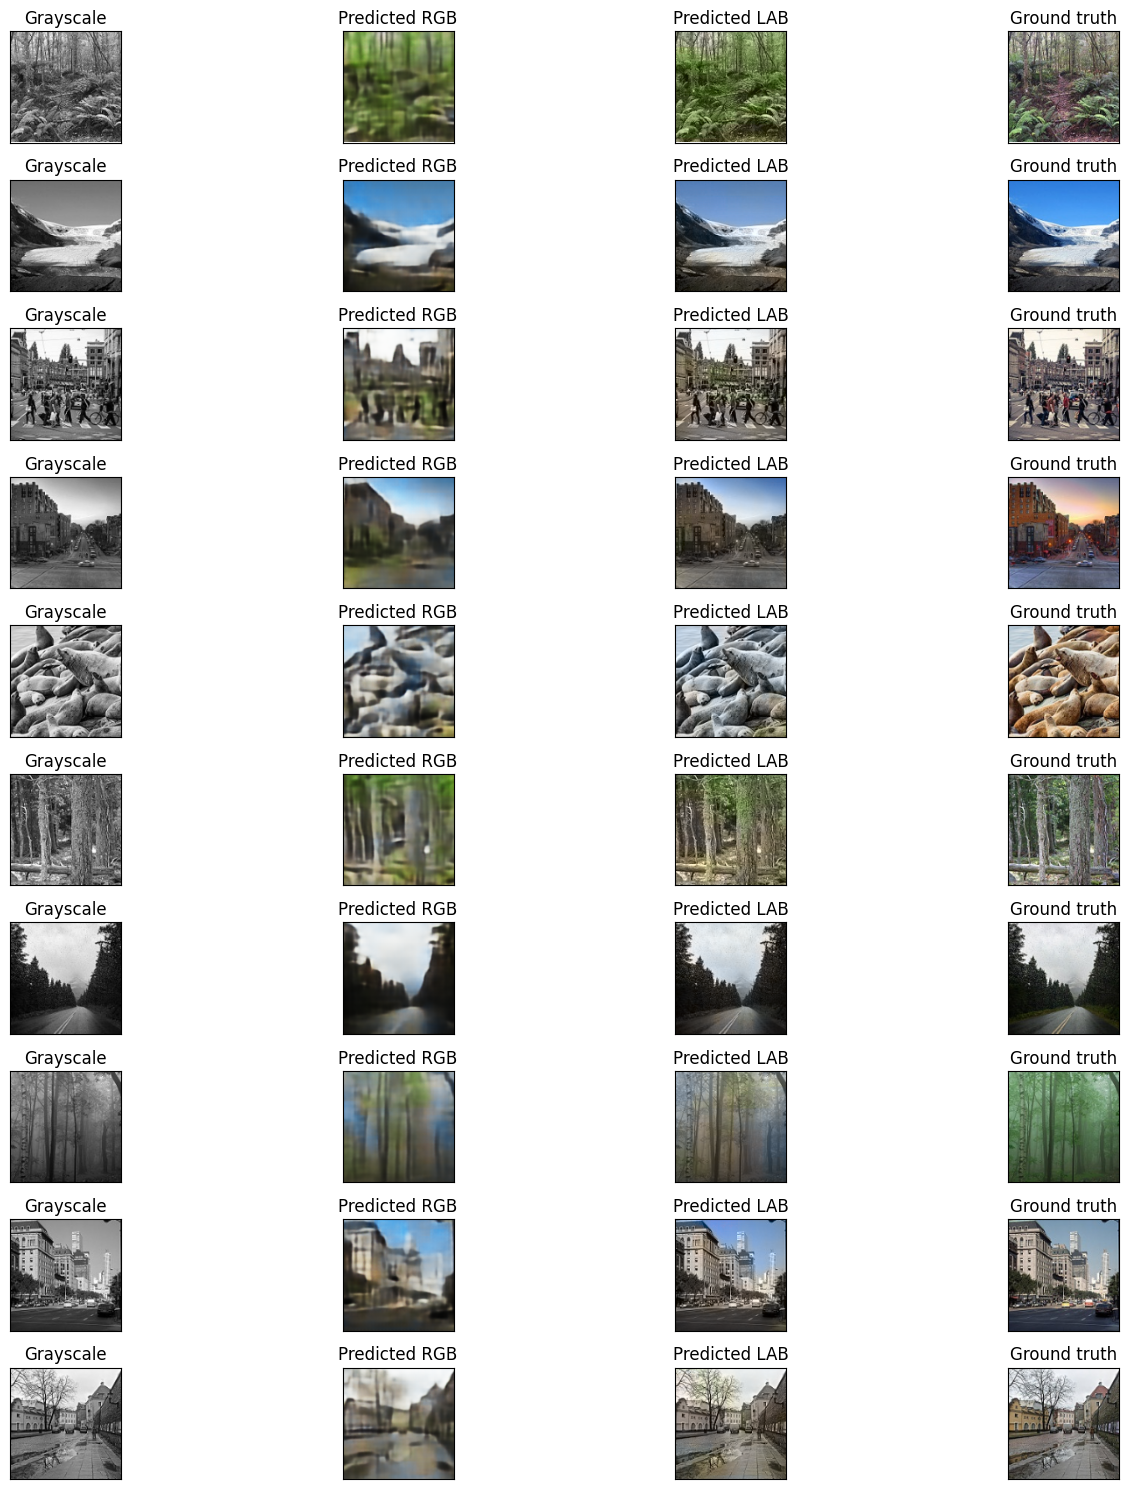

In [ ]:
plot_results(best_ae1_RGB_model, best_ae1_LAB_model)

# Colorization Autoencoder 2 - Skip Connections e Batch Normalization

La seconda architettura definita e implementata (AE2) nasce da alcune **riflessioni** sorte dall’**analisi** e dall'**osservazione dei risultati** del AE1 presentato sopra. Dopo aver condotto diversi test, i risultati ottenuti con la prima architettura, in particolare utilizzando la codifica RGB, si sono rivelati insoddisfacenti in termini di qualità di ricostruzione. Questo ci ha portato a formulare l’**ipotesi** che la causa potesse risiedere anche nell’**uso dei livelli di pooling** nel decoder.

*Sebbene il pooling sia fondamentale nelle reti e nei task di classificazione, la sua efficacia risulta limitata nel contesto specifico della colorizzazione delle immagini.*

Approfondendo questa ipotesi, abbiamo trovato **numerose considerazioni**, anche scientifiche, che sostengono come l’**impiego di layer di pooling** nei **task di colorazione** possa comportare una **perdita di dettagli importanti**, compromettendo la qualità delle rappresentazioni apprese.

In particolare, alcuni studi propongono architetture che **sostituiscono** il **pooling** con **convoluzioni a stride maggiore**, riducendo così la dimensione spaziale senza perdere informazioni cruciali. Questa strategia è motivata dalla necessità di **preservare i dettagli spaziali fini**, indispensabili per ottenere una **colorizzazione accurata** e di **alta qualità**.

Di conseguenza, abbiamo progettato la seconda architettura adottando convoluzioni con stride maggiori per il downsampling, eliminando i livelli di pooling, al fine di migliorare la capacità del modello di mantenere le informazioni necessarie per una ricostruzione cromatica più fedele.

⚠️ Le ipotesi formulate e gli esperimenti condotti NON devono essere interpretati come una **conclusione definitiva** secondo cui i livelli di pooling non siano adatti ai task di colorazione. Al contrario, rappresentano uno **spunto utile** per esplorare **architetture alternative**. In quest’ottica, l’architettura proposta non si limita a rimuovere i layer di pooling e sostituirli con convoluzioni a stride maggiore, ma integra anche altri elementi chiave, come la `Batch Normalization` e, soprattutto, le `Skip Connection`, un componente fondamentale dell’**architettura U-Net**, che verrà descritta qua sotto.

Pertanto, **NON è corretto** attribuire la **bassa qualità della ricostruzione** unicamente alla **presenza dei livelli di pooling**, dal momento che le **modifiche** introdotte nella nuova architettura **coinvolgono più aspetti strutturali**. Proprio per chiarire meglio questo punto, verrà successivamente sviluppata una quarta architettura, pensata per isolare e comprendere con maggiore precisione il **reale impatto** dei livelli di pooling nei task di colorizzazione.

## Che cosa è la U-Net ?

La **U-Net** è un’architettura di **rete neurale convoluzionale** sviluppata inizialmente per la segmentazione di immagini biomediche, ma oggi viene usata con successo in tanti altri ambiti, compresa la colorizzazione.

La sua **struttura** ha proprio la **forma di una “U”** e si compone di due parti principali: un **encoder**, che **comprime le informazioni** riducendo la risoluzione dell’immagine tramite convoluzioni e pooling, e un **decoder**, che serve a riportare l’immagine alla risoluzione originale, **recuperando man mano i dettagli persi**.

A questo punto verrebbe da chiedersi: *ma quindi la U-Net è solo un AutoEncoder un po’ più strutturato?* La risposta è NO, perché c’è un elemento fondamentale che fa davvero la differenza.


## Che cosa sono le skip connection ?
Le **skip connection** sono un **elemento chiave** dell’architettura **U-Net**.
Si tratta di **collegamenti diretti** tra i livelli corrispondenti dell’**encoder** e del **decoder**. In parole semplici, mentre il decoder si occupa di ricostruire l’immagine a partire da una rappresentazione compressa, le **skip connection** gli permettono di ricevere anche le **informazioni originarie** provenienti dall’encoder, che contengono ancora tutti i dettagli spaziali come contorni, bordi e texture fini, che altrimenti rischierebbero di andare persi durante il processo di compressione.

Questo meccanismo è estremamente utile: da un lato **preserva i dettagli più delicati** dell’immagine, **migliorando la qualità della ricostruzione**; dall’altro, aiuta anche durante l’addestramento, perché **facilita la propagazione del gradiente** nei livelli profondi della rete, rendendo tutto il processo più **stabile** ed **efficiente**.

In [ ]:
@saving.register_keras_serializable()
class Colorization_AE2(tf.keras.models.Model):

  def __init__(self, final_activation='sigmoid', final_depth=3, **kwargs):
    super(Colorization_AE2, self).__init__(**kwargs)
    self.final_activation = final_activation
    self.final_depth = final_depth

    self.add_channel_layer = tf.keras.layers.Reshape((128, 128, 1))

    # --- ENCODER ---
    self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)
    self.bn1 = tf.keras.layers.BatchNormalization()

    self.conv2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)
    self.bn2 = tf.keras.layers.BatchNormalization()

    self.conv3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=2)
    self.bn3 = tf.keras.layers.BatchNormalization()

    self.conv4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', strides=2)
    self.bn_encoded = tf.keras.layers.BatchNormalization()

    # --- DECODER ---
    self.convt1 = tf.keras.layers.Conv2DTranspose(512, (3, 3), activation='relu', padding='same', strides=2)
    self.bn_dec1 = tf.keras.layers.BatchNormalization()
    self.merge1 = tf.keras.layers.Concatenate()

    self.convt2 = tf.keras.layers.Conv2DTranspose(256, (3, 3), activation='relu', padding='same', strides=2)
    self.bn_dec2 = tf.keras.layers.BatchNormalization()
    self.merge2 = tf.keras.layers.Concatenate()

    self.convt3 = tf.keras.layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2)
    self.bn_dec3 = tf.keras.layers.BatchNormalization()
    self.merge3 = tf.keras.layers.Concatenate()

    self.convt4 = tf.keras.layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2)
    self.bn_dec4 = tf.keras.layers.BatchNormalization()

    self.conv_final1 = tf.keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')
    self.bn_final1 = tf.keras.layers.BatchNormalization()

    self.outputs_layer = tf.keras.layers.Conv2D(final_depth, (3, 3), activation=self.final_activation, padding='same')


  def call(self, x):

    x = self.add_channel_layer(x)

    # --- ENCODER ---
    conv1 = self.conv1(x)
    bn1 = self.bn1(conv1)

    conv2 = self.conv2(bn1)
    bn2 = self.bn2(conv2)

    conv3 = self.conv3(bn2)
    bn3 = self.bn3(conv3)

    conv4 = self.conv4(bn3)
    encoded = self.bn_encoded(conv4)

    # --- DECODER ---
    convt1 = self.convt1(encoded)
    bn_dec1 = self.bn_dec1(convt1)
    merge1 = self.merge1([bn_dec1, bn3])

    convt2 = self.convt2(merge1)
    bn_dec2 = self.bn_dec2(convt2)
    merge2 = self.merge2([bn_dec2, bn2])

    convt3 = self.convt3(merge2)
    bn_dec3 = self.bn_dec3(convt3)
    merge3 = self.merge3([bn_dec3, bn1])

    convt4 = self.convt4(merge3)
    bn_dec4 = self.bn_dec4(convt4)

    conv_final1 = self.conv_final1(bn_dec4)
    bn_final1 = self.bn_final1(conv_final1)

    outputs = self.outputs_layer(bn_final1)
    return outputs

  def get_config(self):
      config = super().get_config()
      config.update({
          'final_activation': self.final_activation,
          'final_depth': self.final_depth
      })
      return config

  @classmethod
  def from_config(cls, config):
        return cls(**config)

Adesso che abbiamo capito cos’è una U-Net e quale sia l'importanza delle skip connection, possiamo **descrivere l'architettura** che è stata implementata.

Per via della presenza delle skip connection, non è stato possibile mantenere la stessa struttura adottata nell’AE1, dove encoder e decoder erano gestiti come due blocchi separati, definiti tramite classi `Sequential`.

Anche in questo caso, si è scelto di implementare l'intera rete all’interno di una **classe custom**, così da avere il pieno controllo sulla definizione della rete e poter **gestire correttamente i collegamenti** tra i livelli dell’encoder e quelli del decoder.

L'architettura è così definita:
- **Encoder**: è composto da **4 layer `Conv2D()`** con `strides=2` e funzione di attivazione `ReLU`, seguiti ciascuno da un layer di **`BatchNormalization()`**.

- **Decoder**: è costituito da **5 layer `Conv2DTranspose()`** con `strides=2` e attivazione `ReLU`, ciascuno seguito da un layer di **`BatchNormalization()`**. I primi tre livelli del decoder includono anche dei livelli **`Concatenate()`** con i corrispondenti layer dell’encoder, realizzando così le *skip connection* che permettono di **recuperare i dettagli persi** durante la fase di downsampling.

- **layer `Conv2D()` finale**:  restituisce l’output dell’intera rete. Questo layer utilizza una **funzione di attivazione** e un **numero di canali finali parametrizzabili**, in base al tipo di codifica cromatica scelta, come spiegato precedentemente.

In [ ]:
#@title Istanza di ae2 RGB
autoencoder2_RGB = Colorization_AE2(final_activation='sigmoid', final_depth=3)
dummy_input = tf.random.normal([1, 128, 128, 1])

# Simuliamo un forward pass con il dummy input creato sopra
autoencoder2_RGB(dummy_input)

# Stampiamo la struttura interna dell'intero autoencoder per visulizzare i singoli livelli
autoencoder2_RGB.summary()

Model: "colorization_ae2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (1, 128, 128, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (1, 64, 64, 64)        │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (1, 64, 64, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (1, 32, 32, 128)       │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (1, 32, 32, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (1, 16, 16, 256)       │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (1, 16, 16, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (1, 8, 8, 512)         │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (1, 8, 8, 512)         │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_24             │ (1, 16, 16, 512)       │     2,359,808 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (1, 16, 16, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate (Concatenate)       │ (1, 16, 16, 768)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_25             │ (1, 32, 32, 256)       │     1,769,728 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (1, 32, 32, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate_1 (Concatenate)     │ (1, 32, 32, 384)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_26             │ (1, 64, 64, 128)       │       442,496 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (1, 64, 64, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate_2 (Concatenate)     │ (1, 64, 64, 192)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_27             │ (1, 128, 128, 64)      │       110,656 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,259,651 (23.88 MB)

 Trainable params: 6,255,747 (23.86 MB)

 Non-trainable params: 3,904 (15.25 KB)

In [ ]:
#@title Istanza di ae2 LAB
autoencoder2_LAB = Colorization_AE2(final_activation='tanh', final_depth=2)
dummy_input = tf.random.normal([1, 128, 128, 1])

# Simuliamo un forward pass con il dummy input creato sopra
autoencoder2_LAB(dummy_input)

# Stampiamo la struttura interna dell'intero autoencoder per visulizzare i singoli livelli
autoencoder2_LAB.summary()

Model: "colorization_ae2_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (1, 128, 128, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (1, 64, 64, 64)        │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (1, 64, 64, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (1, 32, 32, 128)       │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (1, 32, 32, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (1, 16, 16, 256)       │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (1, 16, 16, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (1, 8, 8, 512)         │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (1, 8, 8, 512)         │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_29             │ (1, 16, 16, 512)       │     2,359,808 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (1, 16, 16, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate_3 (Concatenate)     │ (1, 16, 16, 768)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_30             │ (1, 32, 32, 256)       │     1,769,728 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (1, 32, 32, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate_4 (Concatenate)     │ (1, 32, 32, 384)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_31             │ (1, 64, 64, 128)       │       442,496 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (1, 64, 64, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate_5 (Concatenate)     │ (1, 64, 64, 192)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_32             │ (1, 128, 128, 64)      │       110,656 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,259,362 (23.88 MB)

 Trainable params: 6,255,458 (23.86 MB)

 Non-trainable params: 3,904 (15.25 KB)

## Definizione dei checkpoint per addestrare il modello - AE2

Definiamo un **nuovo percorso** in cui salvare i **modelli migliori** relativi alla **seconda architettura**, e creiamo la nuova lista di `callback`.

Gli elementi delle callback saranno *sostanzialmente identici* a quelli utilizzati in precedenza, ad eccezione del path di salvataggio. Per coerenza con l’approccio adottato nell’AE1, utilizziamo come metrica di riferimento la `val_loss` e manteniamo un criterio di `EarlyStopping` con una **pazienza di 5 epoche**.

In [ ]:
# Creiamo le cartelle `best_models/best_ae2` per salvare il miglior modello e successivamente lo storico delle loss in un csv
best_ae2 = '/content/drive/MyDrive/DL_project/AE/best_models/best_ae2'
os.makedirs(best_ae2, exist_ok=True)

### RGB

In [ ]:
best_ae2_RGB_path = os.path.join(best_ae2, 'best_ae2_RGB_model.keras')

In [ ]:
# Tale configurazione permette di salvare l'intero modello, inclusa l'architettura della rete, la configurazione dell'ottimizzatore e i pesi (`save_weights_only=False`)
# Settando `save_best_only=True` salva il modello con la val_loss migliore, che alla fine dell'addestramento sarà il migliore globale
callbacks_list_RGB = [
    tf.keras.callbacks.ModelCheckpoint(
      filepath = best_ae2_RGB_path,
      monitor="val_loss",
      verbose=0,
      save_best_only=True,
      save_weights_only=False,
      mode="min",
      save_freq="epoch"
    ),

    tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',
      patience=7
    )
]

### LAB

In [ ]:
best_ae2_LAB_path = os.path.join(best_ae2, 'best_ae2_LAB_model.keras')

In [ ]:
callbacks_list_LAB = [
    tf.keras.callbacks.ModelCheckpoint(
      filepath = best_ae2_LAB_path,
      monitor="val_loss",
      verbose=0,
      save_best_only=True,
      save_weights_only=False,
      mode="min",
      save_freq="epoch"
    ),

    tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',
      patience=7
    )
]

##Fit del modello - AE2

Compiliamo i modelli con l’ottimizzatore `Adam` e un `learning rate` pari a `1e-3`.

Procediamo con l’addestramento per **50 epoche**, utilizzando un `batch size=32`, monitorando la`val_los`s e applicando le `callback` precedentemente definite.

###RGB

In [ ]:
autoencoder2_RGB.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.MeanSquaredError())
history_ae2_RGB = autoencoder2_RGB.fit(X_gray_train, y_color_train, epochs=50, shuffle=True, validation_data=(X_gray_val, y_color_val), batch_size=32, callbacks=[callbacks_list_RGB])

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 31s 130ms/step - loss: 0.0301 - val_loss: 0.0103
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0096 - val_loss: 0.0076
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0072 - val_loss: 0.0068
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0064 - val_loss: 0.0079
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0064 - val_loss: 0.0065
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0057 - val_loss: 0.0061
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0058 - val_loss: 0.0064
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0056 - val_loss: 0.0056
Epoch 9/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0056 - val_loss: 0.0057
Epoch 10/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 11/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0053 - val_loss: 0.0055
Epoch 12/50
147/147 ━━━━━━━━━━━━━━━━━━━

###LAB

In [ ]:
autoencoder2_LAB.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.MeanSquaredError())
history_ae2_LAB = autoencoder2_LAB.fit(X_L_train, y_AB_train, epochs=50, shuffle=True, validation_data=(X_L_val, y_AB_val), batch_size=32, callbacks=[callbacks_list_LAB])

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step - loss: 0.0124 - val_loss: 0.0117
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0108 - val_loss: 0.0098
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0089 - val_loss: 0.0091
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0088 - val_loss: 0.0095
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0089 - val_loss: 0.0093
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0084 - val_loss: 0.0091
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0082 - val_loss: 0.0096
Epoch 9/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0085 - val_loss: 0.0084
Epoch 10/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0081 - val_loss: 0.0085
Epoch 11/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0084 - val_loss: 0.0082
Epoch 12/50
147/147 ━━━━━━━━━━━━━━━━━━━━

##Salvataggio della history del modello - AE2



###RGB

In [ ]:
df_history_ae2_RGB = pd.DataFrame(history_ae2_RGB.history)

# Salviamo in un file CSV, nella cartella `best_ae2`
df_history_ae2_RGB.to_csv(os.path.join(best_ae2, 'model2_training_log_RGB.csv'), index=False)

###LAB

In [ ]:
df_history_ae2_LAB = pd.DataFrame(history_ae2_LAB.history)

# Salviamo anche questi risultati in un file csv sempre dentro la stessa cartella `best_ae2`ma nominando diversamente il file
df_history_ae2_LAB.to_csv(os.path.join(best_ae2, 'model2_training_log_LAB.csv'), index=False)

## Caricamento miglior modello - AE2

In [ ]:
#@title RGB
# Verifica che il file (contenente il miglior modello) esista prima di caricarlo in `best_ae2_RGB_model`
if best_ae2_RGB_path:
    print(f'Caricamento del miglior modello dal path: {best_ae2_RGB_path}')

    # Carica il modello con i pesi dell'epoca migliore registrata durante il training
    best_ae2_RGB_model = tf.keras.models.load_model(best_ae2_RGB_path)

else:
    print(f"Errore: Il file del miglior modello non è stato trovato a {best_ae2_RGB_path}")
    # In caso di errore (il file del modello migliore non è stato creato) useremo il modello finale addestrato (che potrebbe non essere il migliore)
    best_ae2_RGB_model = autoencoder2_RGB
    print("Utilizzo il modello finale addestrato invece del migliore.")

Caricamento del miglior modello dal path: /content/drive/MyDrive/DL_project/AE/best_models/best_ae2/best_ae2_RGB_model.keras


In [ ]:
#@title LAB
# Verifica che il file (contenente il miglior modello) esista prima di caricarlo in `best_ae2_LAB_model`
if best_ae2_LAB_path:
    print(f'Caricamento del miglior modello dal path: {best_ae2_LAB_path}')

    # Carica il modello con i pesi dell'epoca migliore registrata durante il training
    best_ae2_LAB_model = tf.keras.models.load_model(best_ae2_LAB_path)

else:
    print(f"Errore: Il file del miglior modello non è stato trovato a {best_ae2_LAB_path}")
    # In caso di errore (il file del modello migliore non è stato creato) useremo il modello finale addestrato (che potrebbe non essere il migliore)
    best_ae2_LAB_model = autoencoder2_LAB
    print("Utilizzo il modello finale addestrato invece del migliore.")

Caricamento del miglior modello dal path: /content/drive/MyDrive/DL_project/AE/best_models/best_ae2/best_ae2_LAB_model.keras


## Valutazione sul test e Stampa delle predizioni - AE2

In [ ]:
#@title RGB
print('Valutazione modello su set di test RGB:')
pred_rgb = best_ae2_RGB_model.predict(X_gray_test)
ssim_rgb = compute_ssim_batch(y_color_test, pred_rgb)

print(f'SSIM (RGB): {ssim_rgb.numpy():.4f}')

Valutazione modello su set di test RGB:
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step
SSIM (RGB): 0.9357


In [ ]:
#@title LAB
# predizioni del modello con codifica lab (predizione lab dei canali AB)
pred_ab = best_ae2_LAB_model.predict(X_L_test)

# Denormalizzazione di LAB per poter convertire in rgb
pred_lab = denormalize_lab(X_L_test, pred_ab)   # prima convertiamo la concatenazione tra il canale L di test e i canali AB predetti
true_lab = denormalize_lab(X_L_test, y_AB_test) # poi facciamo lo stesso per la concatenazione di L di test e i canali AB reali

# Convertiamo da LAB a RGB
pred_rgb = lab_to_rgb_batch(pred_lab)
true_rgb = lab_to_rgb_batch(true_lab)

print('Valutazione modello su set di test LAB:')
ssim_rgb = compute_ssim_batch(true_rgb, pred_rgb)

print(f'SSIM (LAB): {ssim_rgb.numpy():.4f}')

45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
Valutazione modello su set di test LAB:
SSIM (LAB): 0.9444


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


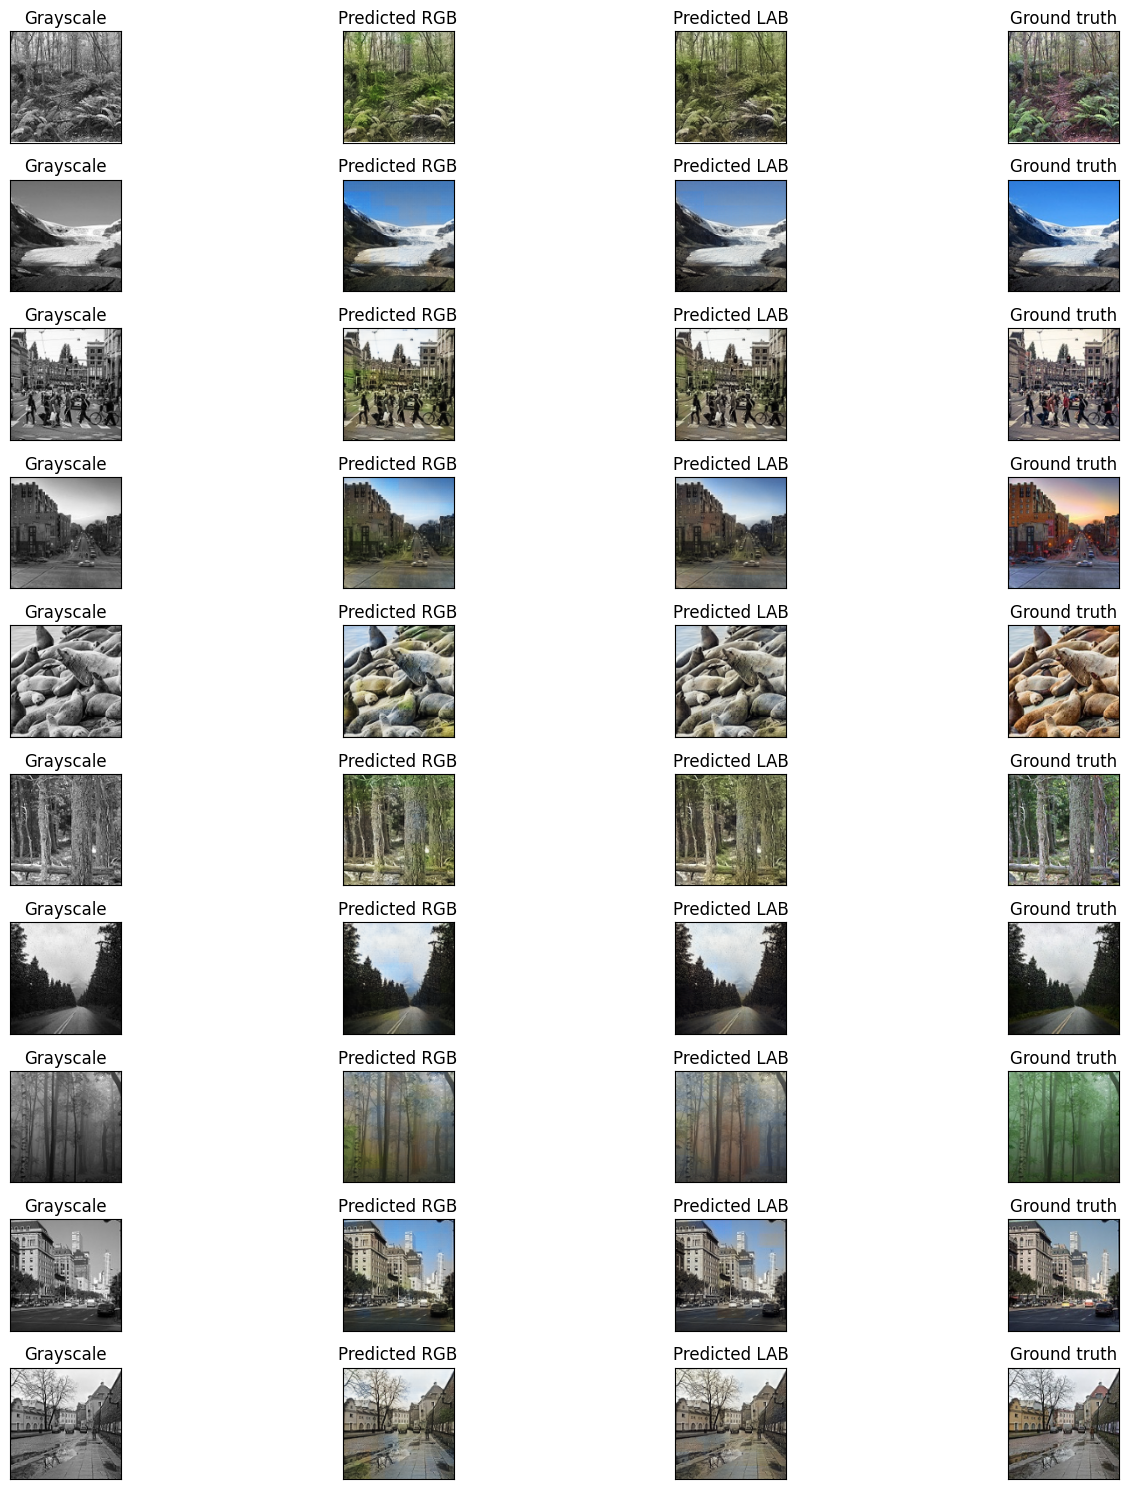

In [ ]:
plot_results(best_ae2_RGB_model, best_ae2_LAB_model)

# Colorization Autoencoder 3 - Encoder Preaddestrato VGG16

L’idea alla base del terzo modello è nata dalla volontà di **costruire una baseline** che sfruttasse un **modello pre-addestrato come encoder**, ipotizzando che l’utilizzo di feature già apprese potesse migliorare le prestazioni nella fase di codifica e offrire una buona rappresentazione dell’immagine anche in un **contesto diverso** come la **colorizzazione**.

Anche in questo caso, l’architettura è stata definita attraverso una classe custom. All’interno del metodo **`__init__`**, sono stati inizializzati alcuni attributi utili per parametrizzare l’ultimo layer e configurare correttamente il modello. In particolare, è stato caricato **`VGG16`** con i pesi **pre-addestrati** su **ImageNet**, impostando il parametro **`include_top=False`** per **escludere i livelli densamente connessi finali**, che risultano inutili per il nostro task di ricostruzione e sono specifici per la classificazione.

Poiché la rete **VGG16** si aspetta **input** con shape **(IMG_SIZE, IMG_SIZE, 3)** (ovvero immagini RGB), è stato necessario effettuare una conversione da 3 a 1 canale, dato che i nostri input sono **immagini in scala di grigi**. Inoltre, l’**output** del modello VGG è stato **forzato a un livello intermedio specifico**, così da **garantire** che la dimensione dello spazio latente creato, fosse compatibile con quella richiesta dal decoder.

Il decoder, invece, è stato definito come un oggetto Sequential, esattamente come nel primo modello. È composto da 6 layer **`Conv2DTranspose()`** con funzione di attivazione **`ReLU`** e uno strato **`Conv2D()`** finale, responsabile di generare l’output finale dell’immagine con il numero di canali e la funzione di attivazione parametrizzabili definiti sopra.

In [ ]:
@saving.register_keras_serializable()
class Colorization_AE3(tf.keras.models.Model):

  def __init__(self, final_activation='sigmoid', final_depth=3, **kwargs):
    super(Colorization_AE3, self).__init__(**kwargs)
    self.final_activation = final_activation
    self.final_depth = final_depth

    # Vgg16 prende in input delle immagini che sono a 3 canali, quindi dobbiamo aumentare il numero di canali delle immagini in scala di grigio
    self.input_reshape = tf.keras.layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x))

    # Definiamo il modello VGG16
    vgg16 = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(128,128,3)) #escludiamo i livelli densamente connessi di classificazione
    vgg16.trainable = False # congeliamo i pesi in modo da non modificarli ed utilizzare quelli della rete preaddestrata con imagenet

    self.encoder = tf.keras.models.Model(
        inputs=vgg16.input,
        outputs=vgg16.get_layer('block5_conv3').output
    )

    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Conv2DTranspose(512, (3, 3), activation='relu', padding='same', strides=2),
      tf.keras.layers.Conv2DTranspose(256, (3, 3), activation='relu', padding='same', strides=1),
      tf.keras.layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2),
      tf.keras.layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=1),
      tf.keras.layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2),
      tf.keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2),
      tf.keras.layers.Conv2D(final_depth, (3, 3), activation=self.final_activation, padding='same')])

  def call(self, inputs):
    x = self.input_reshape(inputs)
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

  def get_config(self):
      config = super().get_config()
      config.update({
          'final_activation': self.final_activation,
          'final_depth': self.final_depth
      })
      return config

  @classmethod
  def from_config(cls, config):
      return cls(**config)

In [ ]:
#@title Istanza di ae3 RGB
autoencoder3_RGB = Colorization_AE3(final_activation='sigmoid', final_depth=3)
dummy_input = tf.random.normal([1, 128, 128, 1])

# Simuliamo un forward pass con il dummy input creato sopra
autoencoder3_RGB(dummy_input)

# Stampiamo la struttura interna dell' encoder e del decoder per visulizzare i singoli livelli
autoencoder3_RGB.encoder.summary()
autoencoder3_RGB.decoder.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose_44             │ (1, 16, 16, 512)       │     2,359,808 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_45             │ (1, 16, 16, 256)       │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_46             │ (1, 32, 32, 128)       │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_47             │ (1, 32, 32, 64)        │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_48             │ (1, 64, 64, 64)        │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_49             │ (1, 128, 128, 32)      │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (1, 128, 128, 3)       │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,964,803 (15.12 MB)

 Trainable params: 3,964,803 (15.12 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#@title Istanza di ae3 LAB
autoencoder3_LAB = Colorization_AE3(final_activation='tanh', final_depth=2)
dummy_input = tf.random.normal([1, 128, 128, 1])

# Simuliamo un forward pass con il dummy input creato sopra
autoencoder3_LAB(dummy_input)

# Stampiamo la struttura interna dell' encoder e del decoder per visulizzare i singoli livelli
autoencoder3_LAB.encoder.summary()
autoencoder3_LAB.decoder.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose_50             │ (1, 16, 16, 512)       │     2,359,808 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_51             │ (1, 16, 16, 256)       │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_52             │ (1, 32, 32, 128)       │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_53             │ (1, 32, 32, 64)        │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_54             │ (1, 64, 64, 64)        │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_55             │ (1, 128, 128, 32)      │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (1, 128, 128, 2)       │           578 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,964,514 (15.12 MB)

 Trainable params: 3,964,514 (15.12 MB)

 Non-trainable params: 0 (0.00 B)

## Definizione dei checkpoint per addestrare il modello - AE3

In [ ]:
# Creiamo le cartelle `best_models/best_ae3` per salvare il miglior modello e successivamente lo storico delle loss in un csv
best_ae3 = '/content/drive/MyDrive/DL_project/AE/best_models/best_ae3'
os.makedirs(best_ae3, exist_ok=True)

###RGB

In [ ]:
best_ae3_RGB_path = os.path.join(best_ae3, 'best_ae3_RGB_model.keras')

In [ ]:
# Tale configurazione permette di salvare l'intero modello, inclusa l'architettura della rete, la configurazione dell'ottimizzatore e i pesi (`save_weights_only=False`)
# Settando `save_best_only=False` salva il modello alla fine di ogni epoca, a prescindere che la metrica monitorata (`val_loss`) sia migliorata.
callbacks_list_RGB = [
  tf.keras.callbacks.ModelCheckpoint(
    filepath = best_ae3_RGB_path,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch"
  ),

  tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7
  )
]

###LAB

In [ ]:
best_ae3_LAB_path = os.path.join(best_ae3, 'best_ae3_LAB_model.keras')

In [ ]:
callbacks_list_LAB = [
  tf.keras.callbacks.ModelCheckpoint(
    filepath = best_ae3_LAB_path,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch"
  ),

  tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7
  )
]

##Fit del modello - AE3

###RGB

In [ ]:
autoencoder3_RGB.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.MeanSquaredError())
history_ae3_RGB = autoencoder3_RGB.fit(X_gray_train, y_color_train, epochs=50, shuffle=True, validation_data=(X_gray_val, y_color_val), batch_size=32, callbacks=[callbacks_list_RGB])

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - loss: 0.0619 - val_loss: 0.0467
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0439 - val_loss: 0.0407
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0388 - val_loss: 0.0396
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0370 - val_loss: 0.0373
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0351 - val_loss: 0.0378
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0334 - val_loss: 0.0371
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0327 - val_loss: 0.0361
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0312 - val_loss: 0.0376
Epoch 9/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0303 - val_loss: 0.0363
Epoch 10/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0291 - val_loss: 0.0362
Epoch 11/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0281 - val_loss: 0.0355
Epoch 12/50
147/147 ━━━━━━━━━━━━━━━━━━━

###LAB

In [ ]:
autoencoder3_LAB.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.MeanSquaredError())
history_ae3_LAB = autoencoder3_LAB.fit(X_L_train, y_AB_train, epochs=50, shuffle=True, validation_data=(X_L_val, y_AB_val), batch_size=32, callbacks=[callbacks_list_LAB])

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - loss: 0.0110 - val_loss: 0.0092
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0086 - val_loss: 0.0087
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0085 - val_loss: 0.0085
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0082 - val_loss: 0.0085
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0080 - val_loss: 0.0086
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0078 - val_loss: 0.0084
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0080 - val_loss: 0.0086
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0079 - val_loss: 0.0083
Epoch 9/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0073 - val_loss: 0.0084
Epoch 10/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0072 - val_loss: 0.0082
Epoch 11/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0070 - val_loss: 0.0082
Epoch 12/50
147/147 ━━━━━━━━━━━━━━━━━━━

##Salvataggio della history del modello - AE3

In [ ]:
#@title RGB
df_history_ae3_RGB = pd.DataFrame(history_ae3_RGB.history)

# Salviamo in un file CSV, nella cartella `best_ae3`
df_history_ae3_RGB.to_csv(os.path.join(best_ae3, 'model3_training_log_RGB.csv'), index=False)

In [ ]:
#@title LAB
df_history_ae3_LAB = pd.DataFrame(history_ae3_LAB.history)
# Salviamo anche questi risultati in un file csv sempre dentro la stessa cartella `best_ae3`ma nominando diversamente il file

df_history_ae3_LAB.to_csv(os.path.join(best_ae3, 'model3_training_log_LAB.csv'), index=False)

##Caricamento miglior modello - AE3

In [ ]:
#@title RGB
# Verifica che il file (contenente il miglior modello) esista prima di caricarlo in `best_ae3_RGB_model`
if best_ae3_RGB_path:
    print(f'Caricamento del miglior modello dal path: {best_ae3_RGB_path}')

    # Carica il modello con i pesi dell'epoca migliore registrata durante il training
    best_ae3_RGB_model = tf.keras.models.load_model(best_ae3_RGB_path)

else:
    print(f"Errore: Il file del miglior modello non è stato trovato a {best_ae3_RGB_path}")
    # In caso di errore (il file del modello migliore non è stato creato) useremo il modello finale addestrato (che potrebbe non essere il migliore)
    best_ae3_RGB_model = autoencoder3_RGB
    print("Utilizzo il modello finale addestrato invece del migliore.")

Caricamento del miglior modello dal path: /content/drive/MyDrive/DL_project/AE/best_models/best_ae3/best_ae3_RGB_model.keras


In [ ]:
#@title LAB
# Verifica che il file (contenente il miglior modello) esista prima di caricarlo in `best_ae3_LAB_model`
if best_ae3_LAB_path:
    print(f'Caricamento del miglior modello dal path: {best_ae3_LAB_path}')

    # Carica il modello con i pesi dell'epoca migliore registrata durante il training
    best_ae3_LAB_model = tf.keras.models.load_model(best_ae3_LAB_path)

else:
    print(f"Errore: Il file del miglior modello non è stato trovato a {best_ae3_LAB_path}")
    # In caso di errore (il file del modello migliore non è stato creato) useremo il modello finale addestrato (che potrebbe non essere il migliore)
    best_ae3_LAB_model = autoencoder3_LAB
    print("Utilizzo il modello finale addestrato invece del migliore.")

Caricamento del miglior modello dal path: /content/drive/MyDrive/DL_project/AE/best_models/best_ae3/best_ae3_LAB_model.keras


##Valutazione sul test e Stampa delle predizioni - AE3

In [ ]:
#@title RGB
print('Valutazione modello su set di test RGB:')
pred_rgb = best_ae3_RGB_model.predict(X_gray_test)
ssim_rgb = compute_ssim_batch(y_color_test, pred_rgb)

print(f'SSIM (RGB): {ssim_rgb.numpy():.4f}')

Valutazione modello su set di test RGB:
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
SSIM (RGB): 0.2964


In [ ]:
#@title LAB
# predizioni del modello con codifica lab (predizione lab dei canali AB)
pred_ab = best_ae3_LAB_model.predict(X_L_test)

# Denormalizzazione di LAB per poter convertire in rgb
pred_lab = denormalize_lab(X_L_test, pred_ab)   # prima convertiamo la concatenazione tra il canale L di test e i canali AB predetti
true_lab = denormalize_lab(X_L_test, y_AB_test) # poi facciamo lo stesso per la concatenazione di L di test e i canali AB reali

# Convertiamo da LAB a RGB
pred_rgb = lab_to_rgb_batch(pred_lab)
true_rgb = lab_to_rgb_batch(true_lab)

print('Valutazione modello su set di test LAB:')
ssim_rgb = compute_ssim_batch(true_rgb, pred_rgb)

print(f'SSIM (LAB): {ssim_rgb.numpy():.4f}')

45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
Valutazione modello su set di test LAB:
SSIM (LAB): 0.9422


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


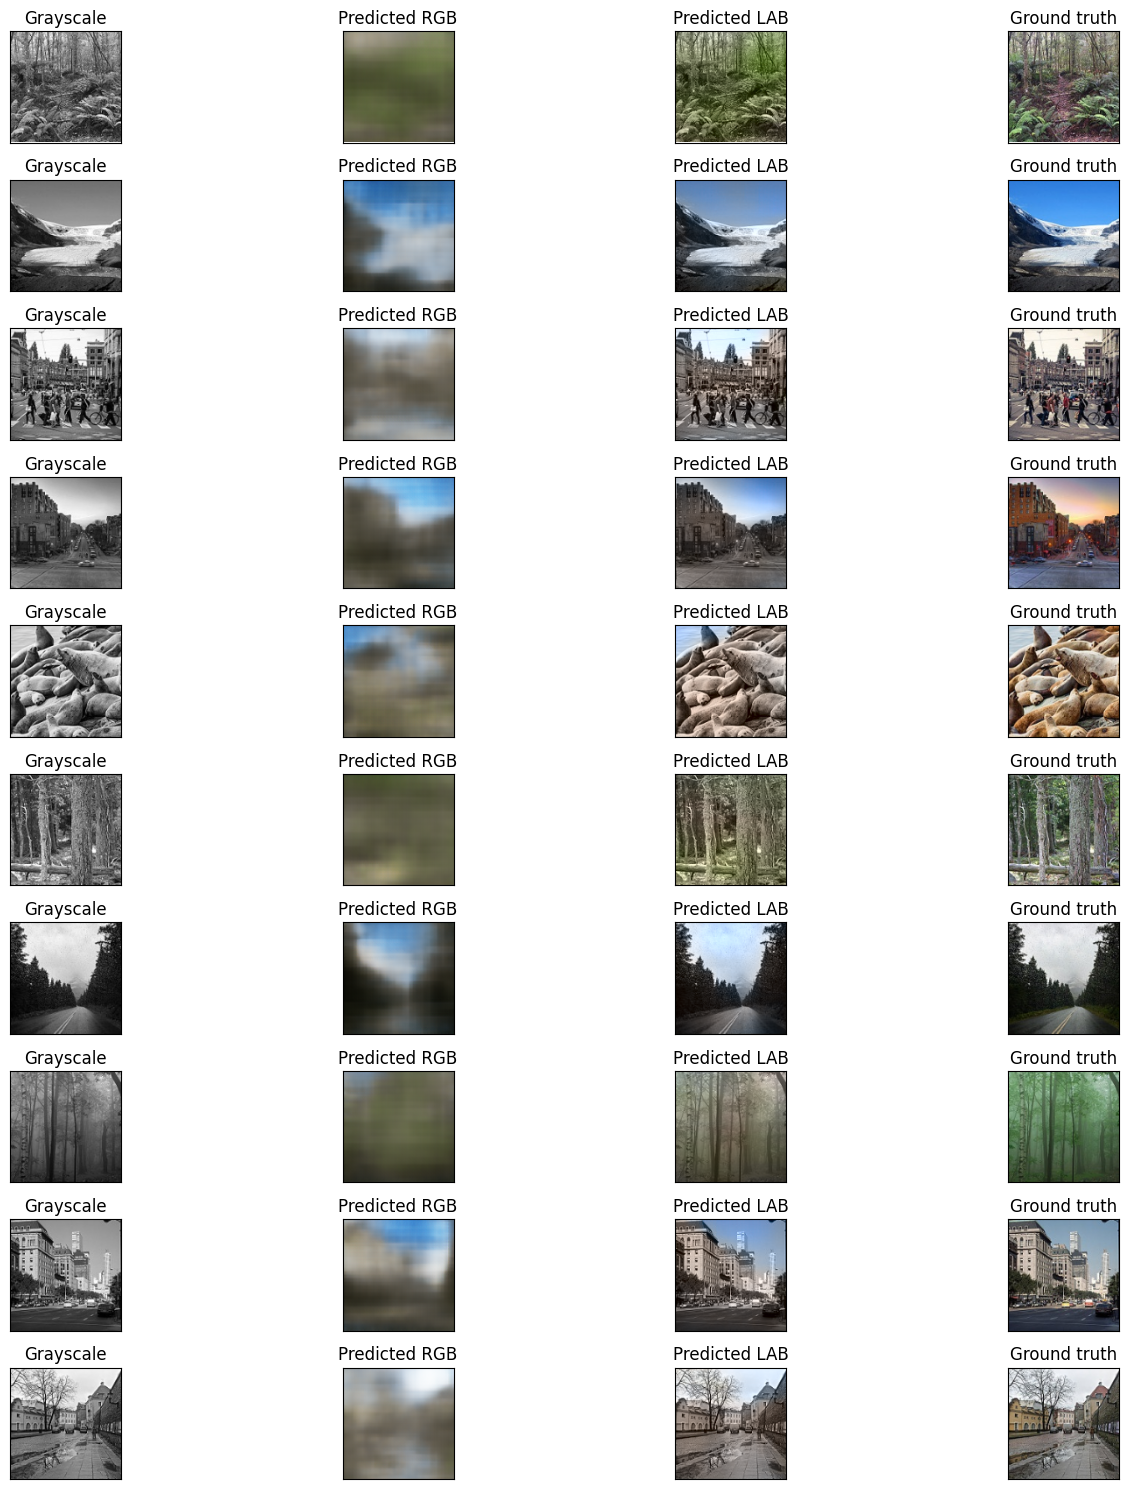

In [ ]:
plot_results(best_ae3_RGB_model, best_ae3_LAB_model)

# Colorization Autoencoder 4 - MaxPooling, Batch Normalization e Skip Connections

Lo **sviluppo** della **quarta architettura** non era inizialmente pianificato, ma si è reso necessario per **chiarire un’ipotesi** emersa durante l’analisi dei risultati ottenuti con la prima rete (AE1). In particolare, ci si è chiesti se la **scarsa qualità di ricostruzione** delle immagini RGB potesse dipendere dalla **presenza dei livelli di pooling** all’interno del decoder.

La seconda architettura (AE2) ha rappresentato un primo tentativo di verifica di questa ipotesi: **rimuovendo i livelli di pooling** e utilizzando al loro posto convoluzioni con stride maggiore, si è effettivamente **osservato un miglioramento significativo** nella **qualità della ricostruzione**.

‼️ *Tuttavia, questa osservazione da sola non è sufficiente per attribuire il miglioramento unicamente all’eliminazione del pooling.*

Infatti, come già evidenziato in precedenza, l' **AE2** introduce un altro elemento fondamentale: le **skip connection**, che permettono al decoder di accedere direttamente alle informazioni spaziali estratte dall’encoder. È quindi possibile che il **miglioramento osservato non sia dovuto tanto alla rimozione dei livelli di pooling**, quanto piuttosto all’**aggiunta** di queste **connessioni residue**.

Con questo dubbio in mente, è nata l’idea della quarta architettura. Il suo obiettivo principale è proprio quello di isolare il contributo delle skip connection e determinare se siano queste ultime a giocare un ruolo determinante nella qualità della ricostruzione, indipendentemente dalla presenza dei livelli di pooling.

La struttura di questo **quarto modello** può essere considerata un **ibrido** tra il primo e il secondo autoencoder sviluppato. In particolare, è stata effettuata una modifica mirata all’architettura dell’encoder: i layer **`Conv2D()`** non utilizzano più **`strides=2`** per il downsampling, come accadeva nella seconda architettura. Al loro posto, sono stati reintrodotti i livelli di **`MaxPooling2D()`**, riprendendo l’approccio usato nel primo modello.

Questa scelta permette di **valutare l’impatto delle sole skip connection**, mantenendo invariata la componente di downsampling basata sul pooling. La modalità con cui sono stati definiti encoder e decoder riprende esattamente quella adottata nella seconda implementazione, proprio per garantire il corretto funzionamento delle connessioni residue tra le due parti della rete.

In [ ]:
@saving.register_keras_serializable()
class Colorization_AE4(tf.keras.models.Model):

  def __init__(self, final_activation='sigmoid', final_depth=3, **kwargs):
    super(Colorization_AE4, self).__init__(**kwargs)
    self.final_activation = final_activation
    self.final_depth = final_depth

    self.add_channel_layer = tf.keras.layers.Reshape((128, 128, 1))

    # --- ENCODER ---
    self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')
    self.mp1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
    self.bn1 = tf.keras.layers.BatchNormalization()

    self.conv2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')
    self.mp2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
    self.bn2 = tf.keras.layers.BatchNormalization()

    self.conv3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')
    self.mp3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
    self.bn3 = tf.keras.layers.BatchNormalization()

    self.conv4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')
    self.mp4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
    self.bn_encoded = tf.keras.layers.BatchNormalization()

    # --- DECODER ---
    self.convt1 = tf.keras.layers.Conv2DTranspose(512, (3, 3), activation='relu', padding='same', strides=2)
    self.bn_dec1 = tf.keras.layers.BatchNormalization()
    self.merge1 = tf.keras.layers.Concatenate()

    self.convt2 = tf.keras.layers.Conv2DTranspose(256, (3, 3), activation='relu', padding='same', strides=2)
    self.bn_dec2 = tf.keras.layers.BatchNormalization()
    self.merge2 = tf.keras.layers.Concatenate()

    self.convt3 = tf.keras.layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2)
    self.bn_dec3 = tf.keras.layers.BatchNormalization()
    self.merge3 = tf.keras.layers.Concatenate()

    self.convt4 = tf.keras.layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2)
    self.bn_dec4 = tf.keras.layers.BatchNormalization()

    self.conv_final1 = tf.keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')
    self.bn_final1 = tf.keras.layers.BatchNormalization()

    self.outputs_layer = tf.keras.layers.Conv2D(final_depth, (3, 3), activation=self.final_activation, padding='same')


  def call(self, x):

    x = self.add_channel_layer(x)

    # --- ENCODER ---
    conv1 = self.conv1(x)
    mp1 = self.mp1(conv1)
    bn1 = self.bn1(mp1)

    conv2 = self.conv2(bn1)
    mp2 = self.mp1(conv2)
    bn2 = self.bn2(mp2)

    conv3 = self.conv3(bn2)
    mp3 = self.mp1(conv3)
    bn3 = self.bn3(mp3)

    conv4 = self.conv4(bn3)
    mp4 = self.mp1(conv4)
    encoded = self.bn_encoded(mp4)

    # --- DECODER ---
    convt1 = self.convt1(encoded)
    bn_dec1 = self.bn_dec1(convt1)
    merge1 = self.merge1([bn_dec1, bn3])

    convt2 = self.convt2(merge1)
    bn_dec2 = self.bn_dec2(convt2)
    merge2 = self.merge2([bn_dec2, bn2])

    convt3 = self.convt3(merge2)
    bn_dec3 = self.bn_dec3(convt3)
    merge3 = self.merge3([bn_dec3, bn1])

    convt4 = self.convt4(merge3)
    bn_dec4 = self.bn_dec4(convt4)

    conv_final1 = self.conv_final1(bn_dec4)
    bn_final1 = self.bn_final1(conv_final1)

    outputs = self.outputs_layer(bn_final1)
    return outputs

  def get_config(self):
      config = super().get_config()
      config.update({
          'final_activation': self.final_activation,
          'final_depth': self.final_depth
      })
      return config

  @classmethod
  def from_config(cls, config):
        return cls(**config)

In [ ]:
#@title Istanza di ae1 RGB
autoencoder4_RGB = Colorization_AE4(final_activation='sigmoid', final_depth=3)
dummy_input = tf.random.normal([1, 128, 128, 1])

# Simuliamo un forward pass con il dummy input creato sopra
autoencoder4_RGB(dummy_input)

# Stampiamo la struttura interna dell' encoder e del decoder per visulizzare i singoli livelli
autoencoder4_RGB.summary()

Model: "colorization_ae4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (1, 128, 128, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (1, 128, 128, 64)      │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (1, 64, 64, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (1, 64, 64, 128)       │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (1, 32, 32, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (1, 32, 32, 256)       │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (1, 16, 16, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (1, 16, 16, 512)       │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (1, 8, 8, 512)         │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (1, 16, 16, 512)       │     2,359,808 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (1, 16, 16, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate (Concatenate)       │ (1, 16, 16, 768)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (1, 32, 32, 256)       │     1,769,728 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (1, 32, 32, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate_1 (Concatenate)     │ (1, 32, 32, 384)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (1, 64, 64, 128)       │       442,496 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,259,651 (23.88 MB)

 Trainable params: 6,255,747 (23.86 MB)

 Non-trainable params: 3,904 (15.25 KB)

In [ ]:
#@title Istanza di ae1 LAB
autoencoder4_LAB = Colorization_AE4(final_activation='tanh', final_depth=2)
dummy_input = tf.random.normal([1, 128, 128, 1])

# Simuliamo un forward pass con il dummy input creato sopra
autoencoder4_LAB(dummy_input)

# Stampiamo la struttura interna dell' encoder e del decoder per visulizzare i singoli livelli
autoencoder4_LAB.summary()

Model: "colorization_ae4_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (1, 128, 128, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (1, 128, 128, 64)      │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (1, 64, 64, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (1, 64, 64, 128)       │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (1, 32, 32, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (1, 32, 32, 256)       │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (1, 16, 16, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (1, 16, 16, 512)       │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (1, 8, 8, 512)         │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (1, 16, 16, 512)       │     2,359,808 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (1, 16, 16, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate_3 (Concatenate)     │ (1, 16, 16, 768)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (1, 32, 32, 256)       │     1,769,728 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (1, 32, 32, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate_4 (Concatenate)     │ (1, 32, 32, 384)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (1, 64, 64, 128)       │       442,496 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,259,362 (23.88 MB)

 Trainable params: 6,255,458 (23.86 MB)

 Non-trainable params: 3,904 (15.25 KB)

## Definizione dei checkpoint per addestrare il modello - AE4

### RGB

In [ ]:
# Creiamo le cartelle `best_models/best_ae1` per salvare i miglior modelli e successivamente gli storici delle loss in un csv
# In questa directory verranno salvati i migliori modelli per RGB e LAB, nonchè i relativi storici nei csv
best_ae4 = '/content/drive/MyDrive/DL_project/AE/best_models/best_ae4'
os.makedirs(best_ae4, exist_ok=True)

In [ ]:
best_ae4_RGB_path = os.path.join(best_ae4, 'best_ae4_RGB_model.keras')

In [ ]:
# Tale configurazione permette di salvare l'intero modello, inclusa l'architettura della rete, la configurazione dell'ottimizzatore e i pesi (`save_weights_only=False`)
# Settando `save_best_only=True` salva il modello con la val_loss minore, che alla fine dell' addestramento sarà il migliore globale
callbacks_list_RGB = [

  tf.keras.callbacks.ModelCheckpoint(
    filepath = best_ae4_RGB_path,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch"
  ),

  tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7
  )
]



### LAB

In [ ]:
best_ae4_LAB_path = os.path.join(best_ae4, 'best_ae4_LAB_model.keras')

In [ ]:
callbacks_list_LAB = [
    tf.keras.callbacks.ModelCheckpoint(
      filepath = best_ae4_LAB_path,
      monitor="val_loss",
      verbose=0,
      save_best_only=True,
      save_weights_only=False,
      mode="min",
      save_freq="epoch"
    ),

    tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',
      patience=7
    )
]

## Fit del modello - AE4

### RGB

In [ ]:
# Effettuiamo la prima fit per le immagini con la codifica RGB.
autoencoder4_RGB.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.MeanSquaredError())
history_ae4_RGB = autoencoder4_RGB.fit(X_gray_train, y_color_train, epochs=50, shuffle=True, validation_data=(X_gray_val, y_color_val), batch_size=32, callbacks=[callbacks_list_RGB])

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 106ms/step - loss: 0.0294 - val_loss: 0.0118
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0102 - val_loss: 0.0095
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0082 - val_loss: 0.0077
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0076 - val_loss: 0.0073
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0068 - val_loss: 0.0081
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0063 - val_loss: 0.0073
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0063 - val_loss: 0.0061
Epoch 9/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0060 - val_loss: 0.0062
Epoch 10/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0059 - val_loss: 0.0063
Epoch 11/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0057 - val_loss: 0.0075
Epoch 12/50
147/147 ━━━━━━━━━━━━━━━━━━━

### LAB

In [ ]:
# Effettuiamo la seconda fit per le immagini con la codifica LAB.
autoencoder4_LAB.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.MeanSquaredError())
history_ae4_LAB = autoencoder4_LAB.fit(X_L_train, y_AB_train, epochs=50, shuffle=True, validation_data=(X_L_val, y_AB_val), batch_size=32, callbacks=[callbacks_list_LAB])

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 98ms/step - loss: 0.0119 - val_loss: 0.0102
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0097 - val_loss: 0.0097
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0094 - val_loss: 0.0089
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0088 - val_loss: 0.0087
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0087 - val_loss: 0.0090
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0084 - val_loss: 0.0082
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0082 - val_loss: 0.0085
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0080 - val_loss: 0.0086
Epoch 9/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0083 - val_loss: 0.0088
Epoch 10/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0083 - val_loss: 0.0084
Epoch 11/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0078 - val_loss: 0.0080
Epoch 12/50
147/147 ━━━━━━━━━━━━━━━━━━━━

##Salvataggio della history del modello - AE4

In [ ]:
#@title RGB
df_history_ae4_RGB = pd.DataFrame(history_ae4_RGB.history)

# Salviamo in un file CSV, nella cartella `best_ae4`
df_history_ae4_RGB.to_csv(os.path.join(best_ae4, 'model4_training_log_RGB.csv'), index=False)

In [ ]:
#@title LAB
df_history_ae4_LAB = pd.DataFrame(history_ae4_LAB.history)
# Salviamo anche questi risultati in un file csv sempre dentro la stessa cartella `best_ae4`ma nominando diversamente il file

df_history_ae4_LAB.to_csv(os.path.join(best_ae4, 'model4_training_log_LAB.csv'), index=False)

##Caricamento miglior modello - AE4

### RGB

In [ ]:
# Verifica che il file (contenente il miglior modello) esista prima di caricarlo in `best_ae1_RGB_model`
if best_ae4_RGB_path:
    print(f'Caricamento del miglior modello dal path: {best_ae4_RGB_path}')

    # Carica il modello con i pesi dell'epoca migliore registrata durante il training
    best_ae4_RGB_model = tf.keras.models.load_model(best_ae4_RGB_path)

else:
    print(f"Errore: Il file del miglior modello non è stato trovato a {best_ae4_RGB_path}")
    # In caso di errore (il file del modello migliore non è stato creato) useremo il modello finale addestrato (che potrebbe non essere il migliore)
    best_ae4_RGB_model = autoencoder4_RGB
    print("Utilizzo il modello finale addestrato invece del migliore.")

Caricamento del miglior modello dal path: /content/drive/MyDrive/DL_project/AE/best_models/best_ae4/best_ae4_RGB_model.keras


### LAB

In [ ]:
# Verifica che il file (contenente il miglior modello) esista prima di caricarlo in `best_ae1_LAB_model`
if best_ae4_LAB_path:
    print(f'Caricamento del miglior modello dal path: {best_ae4_LAB_path}')

    # Carica il modello con i pesi dell'epoca migliore registrata durante il training
    best_ae4_LAB_model = tf.keras.models.load_model(best_ae4_LAB_path)

else:
    print(f"Errore: Il file del miglior modello non è stato trovato a {best_ae4_LAB_path}")
    # In caso di errore (il file del modello migliore non è stato creato) useremo il modello finale addestrato (che potrebbe non essere il migliore)
    best_ae4_LAB_model = autoencoder4_LAB
    print("Utilizzo il modello finale addestrato invece del migliore.")

Caricamento del miglior modello dal path: /content/drive/MyDrive/DL_project/AE/best_models/best_ae4/best_ae4_LAB_model.keras


##Valutazione sul test e Stampa delle predizioni - AE4

In [ ]:
#@title RGB
print('Valutazione modello su set di test RGB:')
pred_rgb = best_ae4_RGB_model.predict(X_gray_test)
ssim_rgb = compute_ssim_batch(y_color_test, pred_rgb)

print(f'SSIM (RGB): {ssim_rgb.numpy():.4f}')

Valutazione modello su set di test RGB:
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
SSIM (RGB): 0.9200


In [ ]:
#@title LAB
# predizioni del modello con codifica lab (predizione lab dei canali AB)
pred_ab = best_ae4_LAB_model.predict(X_L_test)

# Denormalizzazione di LAB per poter convertire in rgb
pred_lab = denormalize_lab(X_L_test, pred_ab)   # prima convertiamo la concatenazione tra il canale L di test e i canali AB predetti
true_lab = denormalize_lab(X_L_test, y_AB_test) # poi facciamo lo stesso per la concatenazione di L di test e i canali AB reali

# Convertiamo da LAB a RGB
pred_rgb = lab_to_rgb_batch(pred_lab)
true_rgb = lab_to_rgb_batch(true_lab)

print('Valutazione modello su set di test LAB:')
ssim_rgb = compute_ssim_batch(true_rgb, pred_rgb)

print(f'SSIM (LAB): {ssim_rgb.numpy():.4f}')

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Valutazione modello su set di test LAB:
SSIM (LAB): 0.9453


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


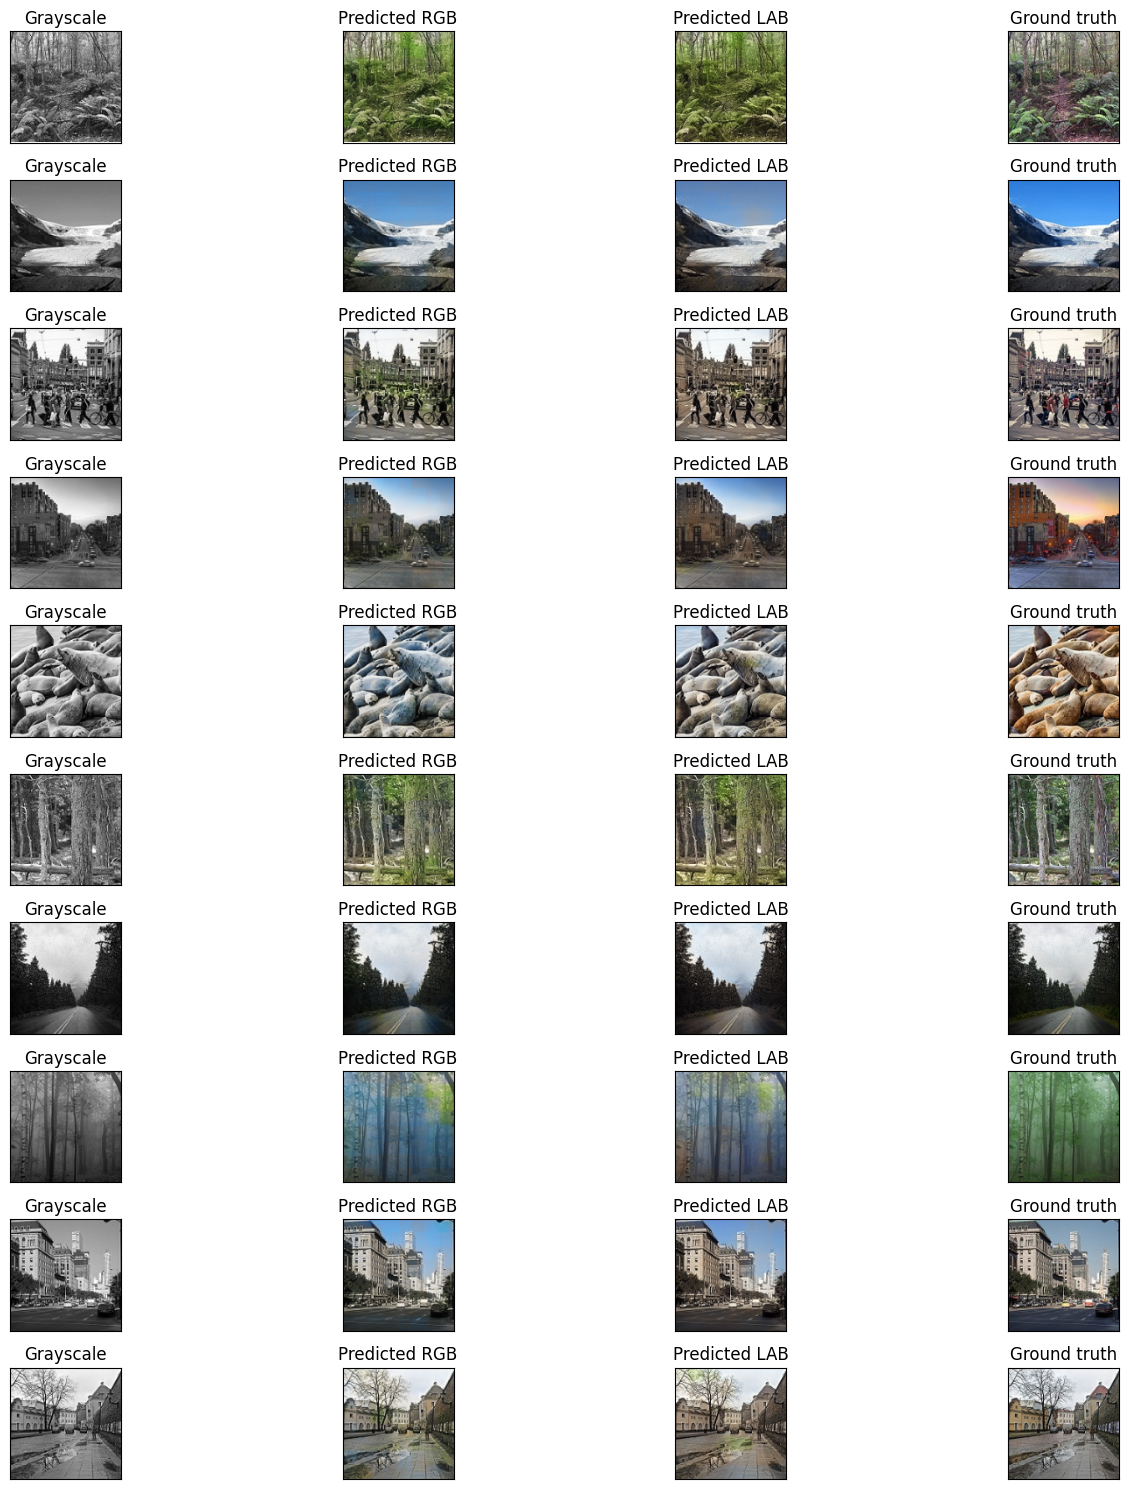

In [ ]:
plot_results(best_ae4_RGB_model, best_ae4_LAB_model)

# Risultati

Per confrontare i modelli appena creati, utilizzeremo dei grafici che mostrano l'**andamento della loss** durante le diverse **epoche**, sia sul **set di training** che su quello di **validazione**. I grafici verranno generati a partire dai file `.csv` precedentemente salvati, contenenti i valori della loss per ogni epoca.

Oltre all’analisi della loss, effettueremo un confronto basato sulla **SSIM** (*Structural Similarity Index Measure*), una metrica descritta in precedenza che valuta la **somiglianza tra immagini** considerando aspetti come **luminosità**, **contrasto** e **struttura**.

*Questa metrica ci fornirà una valutazione qualitativa più accurata delle prestazioni dei modelli nella ricostruzione delle immagini.*

In [ ]:
def read_csv(directory_path, color_encoding):

    file_found = None

    # Cerca il file che termina con la codifica colore specificata e l'estensione .csv
    for filename in os.listdir(directory_path):
        if filename.endswith(f"{color_encoding}.csv"):
            file_found = os.path.join(directory_path, filename)
            break

    if file_found is None:
        raise FileNotFoundError(f"Nessun file trovato in {directory_path}")

    # Legge il CSV con pandas
    df = pd.read_csv(file_found)

    return df

Chiamiamo la funzione definita in precedenza per leggere i file CSV e salviamo i dati nei rispettivi DataFrame. Questi, saranno l’input per una funzione dedicata alla visualizzazione dell’andamento della loss, sia sul set di training che su quello di validazione.

In [ ]:
df_bestae1_RGB = read_csv(best_ae1, 'RGB')
df_bestae1_LAB = read_csv(best_ae1, 'LAB')

df_bestae2_RGB = read_csv(best_ae2, 'RGB')
df_bestae2_LAB = read_csv(best_ae2, 'LAB')

df_bestae3_RGB = read_csv(best_ae3, 'RGB')
df_bestae3_LAB = read_csv(best_ae3, 'LAB')

df_bestae4_RGB = read_csv(best_ae4, 'RGB')
df_bestae4_LAB = read_csv(best_ae4, 'LAB')

In [ ]:
def plot_loss_comparison(dfs_rgb, dfs_lab, base_directories):

    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10), sharey=False)
    model_names = ['AE1', 'AE2', 'AE3', 'AE4']

    # Ciclo per tutte e 4 le colonne
    for col in range(4):
        model = model_names[col]

        # --- Riga 0: RGB ---
        ax_rgb = axes[0, col]
        if col < len(dfs_rgb):
            df_rgb = dfs_rgb[col]
            ax_rgb.plot(df_rgb['loss'], label='Train Loss', color='red')
            ax_rgb.plot(df_rgb['val_loss'], label='Validation Loss', color='blue')
            ax_rgb.set_title(f'{model} - RGB', fontsize=14)
            ax_rgb.set_xlabel('Epoch', fontsize=12)
            ax_rgb.set_ylabel('Loss', fontsize=12)
            ax_rgb.grid(True)
            if col == 0:
                ax_rgb.legend(fontsize=10)

            # Salva direttamente il grafico RGB individuale
            if col < len(base_directories):
                fig_rgb, ax_single_rgb = plt.subplots(figsize=(10, 6))
                ax_single_rgb.plot(df_rgb['loss'], label='Train Loss', color='red', linewidth=2)
                ax_single_rgb.plot(df_rgb['val_loss'], label='Validation Loss', color='blue', linewidth=2)
                ax_single_rgb.set_title(f'{model} - RGB', fontsize=16, fontweight='bold')
                ax_single_rgb.set_xlabel('Epoch', fontsize=14)
                ax_single_rgb.set_ylabel('Loss', fontsize=14)
                ax_single_rgb.grid(True, alpha=0.7)
                ax_single_rgb.legend(fontsize=12)

                filepath_rgb = os.path.join(base_directories[col], "loss_plot_RGB.png")
                fig_rgb.tight_layout()
                fig_rgb.savefig(filepath_rgb, dpi=300, bbox_inches='tight', facecolor='white')
                plt.close(fig_rgb)

        # --- Riga 1: LAB ---
        ax_lab = axes[1, col]
        if col < len(dfs_lab):
            df_lab = dfs_lab[col]
            ax_lab.plot(df_lab['loss'], label='Train Loss', color='orange')
            ax_lab.plot(df_lab['val_loss'], label='Validation Loss', color='purple')
            ax_lab.set_title(f'{model} - LAB', fontsize=14)
            ax_lab.set_xlabel('Epoch', fontsize=12)
            ax_lab.set_ylabel('Loss', fontsize=12)
            ax_lab.grid(True)
            if col == 0:
                ax_lab.legend(fontsize=10)

            # Salva direttamente il grafico LAB individuale
            if col < len(base_directories):
                fig_lab, ax_single_lab = plt.subplots(figsize=(10, 6))
                ax_single_lab.plot(df_lab['loss'], label='Train Loss', color='orange', linewidth=2)
                ax_single_lab.plot(df_lab['val_loss'], label='Validation Loss', color='purple', linewidth=2)
                ax_single_lab.set_title(f'{model} - LAB', fontsize=16, fontweight='bold')
                ax_single_lab.set_xlabel('Epoch', fontsize=14)
                ax_single_lab.set_ylabel('Loss', fontsize=14)
                ax_single_lab.grid(True, alpha=0.7)
                ax_single_lab.legend(fontsize=12)

                filepath_lab = os.path.join(base_directories[col], "loss_plot_LAB.png")
                fig_lab.tight_layout()
                fig_lab.savefig(filepath_lab, dpi=300, bbox_inches='tight', facecolor='white')
                plt.close(fig_lab)

    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    plt.suptitle("Andamento della Loss per Modello e Codifica Colore", fontsize=18, y=1.02)
    plt.tight_layout()
    plt.show()

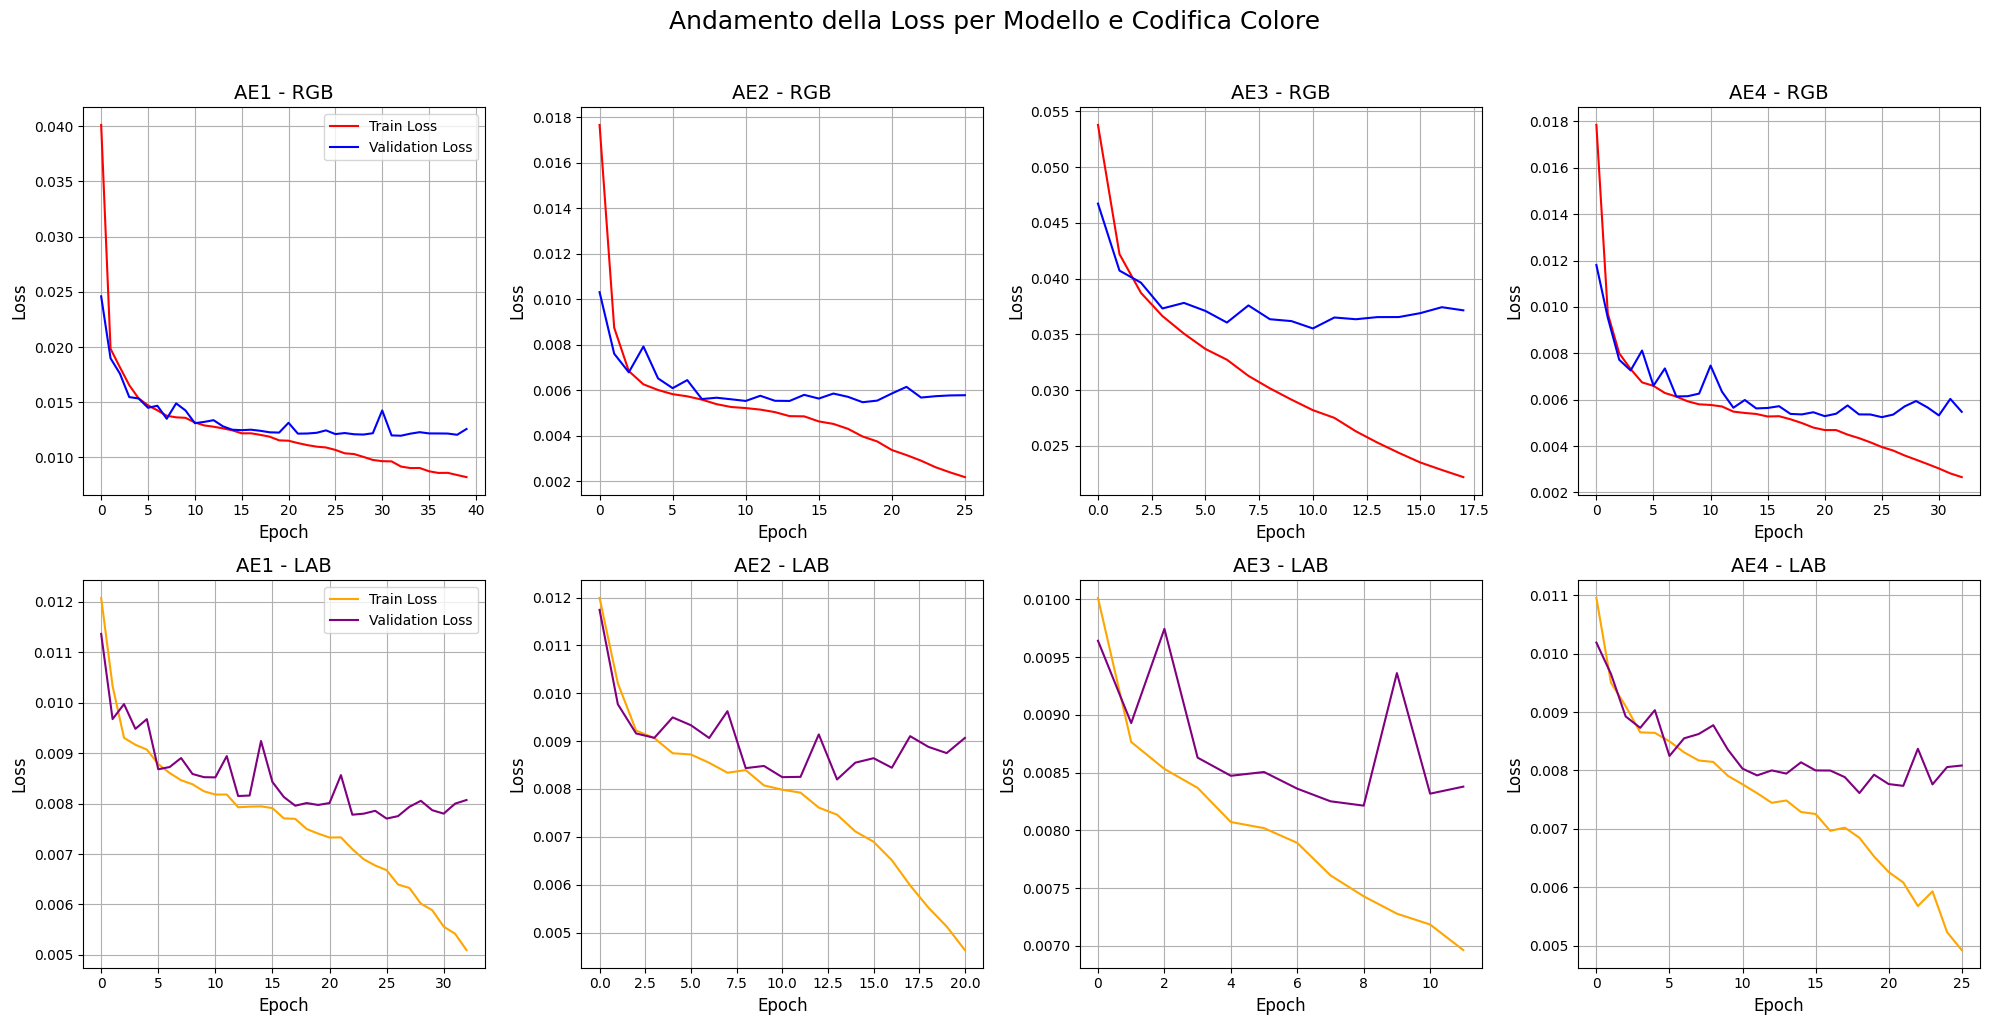

In [ ]:
# Creiamo le liste con i dataframe da passare alla funzione per una corretta stampa
dfs_rgb = [df_bestae1_RGB, df_bestae2_RGB, df_bestae3_RGB, df_bestae4_RGB]
dfs_lab = [df_bestae1_LAB, df_bestae2_LAB, df_bestae3_LAB, df_bestae4_LAB]

# Lista contenente i percorsi per salvare le figure
base_dirs = [best_ae1, best_ae2, best_ae3, best_ae4]

# Chiamata
plot_loss_comparison(dfs_rgb, dfs_lab, base_dirs)

I grafici presentati mostrano, in **generale**, una **riduzione progressiva della loss** sia durante la **fase di training** che in quella di **validazione** sin dalle **prime epoche**. *Questo comportamento è tipico nei modelli neurali, che tendono a imparare rapidamente nelle prime iterazioni.*

Un **aspetto comune a tutti i modelli** è la presenza di una **train loss sistematicamente inferiore rispetto alla validation loss**. Questo fenomeno è del tutto normale: il modello viene ottimizzato sui dati di training (che di fatto ha già visto) mentre la validazione misura la sua capacità di generalizzare su dati non noti. La **discrepanza tra le due curve**, quindi, non è necessariamente sintomo di un malfunzionamento, ma piuttosto una **caratteristica dell’addestramento delle reti neurali**.

Analizzando nel dettaglio le diverse codifiche di colore, si osserva che i **modelli** addestrati con la **codifica RGB** mostrano generalmente **curve di validazione più regolari e stabili**. *Questo suggerisce che i modelli riescano ad adattarsi con maggiore efficacia a questa rappresentazione, mantenendo una traiettoria coerente durante l’apprendimento.*

Al contrario, i **modelli** basati su **codifica LAB** evidenziano una **maggiore instabilità nelle curve di validazione**, con **oscillazioni più marcate** e **picchi più frequenti**. *Questo comportamento potrebbe indicare una maggiore difficoltà nell’apprendere in maniera robusta le informazioni contenute nella codifica LAB.*

Tuttavia, **tale instabilità** non è necessariamente imputabile esclusivamente alla **codifica colore**. Un'altra possibile causa è da ricercarsi nella configurazione dell’ottimizzatore.

Nonostante le osservazioni iniziali sembrino indicare che la **codifica RGB** offra una **maggiore stabilità** e quindi risulti **più adatta al task** in esame, è **importante evitare conclusioni affrettate**. Infatti, la stabilità numerica della loss non sempre si traduce in una migliore qualità percettiva del risultato. Nel contesto della ricostruzione di immagini, è fondamentale affiancare alle metriche di errore anche indicatori che riflettano la percezione umana, nonché metriche che valutino la conservazione della struttura visiva dell’immagine.

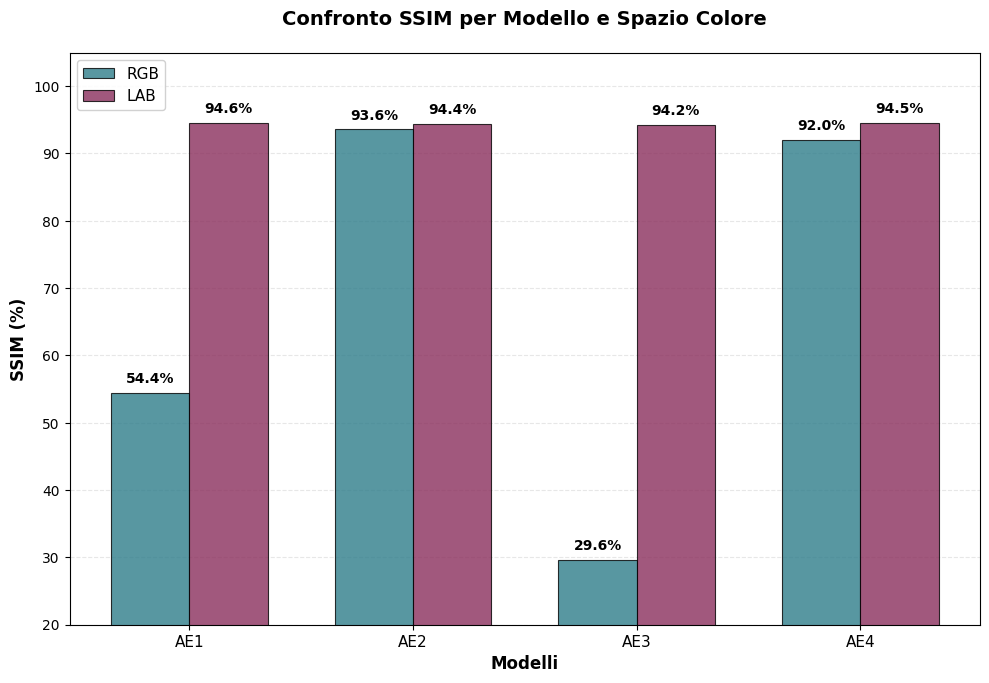

In [ ]:
# Dati SSIM definiti staticamente
ssim_rgb = [0.5440, 0.9357, 0.2964, 0.9200]
ssim_lab = [0.9456, 0.9444, 0.9422, 0.9453]

# Conversione in percentuale
ssim_rgb_percent = [val * 100 for val in ssim_rgb]
ssim_lab_percent = [val * 100 for val in ssim_lab]

# Nomi di ciascun modello come etichetta
models = ['AE1', 'AE2', 'AE3', 'AE4']
x = np.arange(len(models))
width = 0.35

color_rgb = '#2E7D8A'
color_lab = '#8A2E5C'

fig, ax = plt.subplots(figsize=(10, 7))
bars_rgb = ax.bar(x - width/2, ssim_rgb_percent, width,
                  label='RGB', color=color_rgb, alpha=0.8,
                  edgecolor='black', linewidth=0.8)
bars_lab = ax.bar(x + width/2, ssim_lab_percent, width,
                  label='LAB', color=color_lab, alpha=0.8,
                  edgecolor='black', linewidth=0.8)

ax.set_ylabel('SSIM (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Modelli', fontsize=12, fontweight='bold')
ax.set_title('Confronto SSIM per Modello e Spazio Colore',
             fontsize=14, fontweight='bold', pad=20)

# Impostazione ticks
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=11)

ax.set_ylim(20, 105)
ax.grid(True, axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)
ax.legend(fontsize=11, loc='upper left', framealpha=0.9)


for bars, values in [(bars_rgb, ssim_rgb_percent), (bars_lab, ssim_lab_percent)]:
    for bar, value in zip(bars, values):
        height = bar.get_height()
        # Colore del testo contrastante
        text_color = 'white' if height > 80 else 'black'
        ax.annotate(f'{value:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10, fontweight='bold',
                    color='black')

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.show()

Come mostrato nel grafico, in t**utti i modelli** che utilizzano la **codifica LAB**, la **metrica SSIM** risulta **generalmente più elevata rispetto alla controparte RGB**. *Questo suggerisce una migliore qualità di ricostruzione visiva quando si adotta tale rappresentazione cromatica.*

Un'altra osservazione interessante riguarda la **relazione** tra **architettura** del modello e **codifica** del **colore**. I modelli **AE1** e **AE3**, strutturati come ***autoencoder classici*** (senza skip connection), ottengono **punteggi SSIM** piuttosto **bassi** con la **codifica RGB**, indicando una **qualità di ricostruzione limitata**.

Al contrario, i modelli **AE2** e **AE4**, basati su **architettura U-Net** con *skip connection* (e utilizzando la codifica RGB), raggiungono **performance molto più elevate**, comparabili, a **quelle ottenute con LAB**.

Da queste evidenze emergono alcune considerazioni utili per orientare le scelte progettuali. È possibile, ad esempio, adottare **modelli strutturalmente più semplici** (come gli autoencoder classici) se si è disposti a investire **maggior** tempo nella fase di **pre-processing**, utilizzando la **codifica LAB**.

*Questa scelta, infatti, comporta operazioni aggiuntive come la separazione e successiva concatenzazione dei canali L e AB, che si riflettono in tempi di training e validazione più lunghi.*

Viceversa, si può optare per la **codifica RGB**, che richiede** meno elaborazione preliminare**, a patto però di adottare **modelli più sofisticati**, come la **U-Net**, in grado di compensare la mancanza di informazione strutturale aggiuntiva, attraverso le skip connection.

# FONTI

 Caricamento dei file

 https://stackoverflow.com/questions/71268961/unable-to-upload-local-files-to-google-colab-file-upload-does-not-respond/78274523

Split del dataset

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html , LAB


Architettura primo modello AE:
alternanza di livelli conv e maxpooling e in un numero maggiore (+ profondo), LAB03 - Convoluzione


Creazione checkpoint per salvare il modello:
https://keras.io/api/callbacks/model_checkpoint/ , LAB 07



Creazione delle cartelle tramite modulo os:
https://www.codegrind.it/documentazione/python/modulo-os, LAB



Creazione modelli custom, serializzazione e caricamento
https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing
https://www.tensorflow.org/guide/keras/serialization_and_saving

Metriche comune di valutazione
https://ar5iv.labs.arxiv.org/html/2308.00471?utm_source=chatgpt.com